In [1]:
library(repr)

options(repr.plot.width=8, repr.plot.height=5, repr.plot.res = 200)#hidden code for display size


# Linear Mixed Models : application to data in cognitive science

## Module 2 : Introducing the shotgun


 &nbsp;
 &nbsp;
 &nbsp;

 <center> Gabriel Weindel, PhD, April 2021 at AMU </center>



> "encouraging psycholinguists to use linear mixed-effects models \[is\]
like giving shotguns to toddlers” (Prominent psycholinguist cited by Barr et al. 2013)

## Benefits of LMMs

- Extending linear models to within design
- Data pooling, learning about one participants informs you about the other participant
- No pre-averaging
- Accounting for imbalance in sampling

## Costs of LMMs

- More decisions have to be made
- Hard to understand as we have multiple levels
- Implement and computation power


# Organization of the second module

1. Maximum likelihood estimation
1. What are hierarchies in the data 
2. Formalism behind LMM
1. Illustrating the concept of random effects
2. Adding predictor
3. Full LMM


# Maximum likelihood estimation

This bit is intended to give you an intuition about MLE but see the paper by Myung [2003](https://www.sciencedirect.com/science/article/abs/pii/S0022249602000287) for an accessible tutorial

We are going to flip coins to illustrate the concept 

What is the probability of $x$ number of heads given $n$ coin flips

$$ 
P(x|n,p) =  \frac{n!}{x!(n-x)!} \cdot p^x(1 - p)^{n-x} $$

If I come up with 28 heads for 40 flips:

With assumpation that the coin is unbiased, _i.e._ $p=0.5$ :


\begin{equation}
P(28|40,.5) =  \frac{40!}{28!(40-28)!} \cdot .5^{28}(1 - .5)^{40-28} \approx .002
\end{equation}

with $p=0.7$ 
\begin{equation}
P(28|40,.7) =  \frac{40!}{28!(40-28)!} \cdot .70^{28}(1 - .7)^{40-28} \approx .137
\end{equation}

Given these results, what is the most likely ? unbiased coin or coin biased towards heads ?

Now moving to continuous DVs same logic applies except that we are not looking at probability mass functions but probability density functions, _e.g._ density of a normal distribution :

  $$ f(x) = \frac{1}{\sigma\sqrt{2\pi}} 
  \exp\left( -\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^{\!2}\,\right) $$

We are looking for the parameter values (_e.g._ $\mu$) that maximises the likelihood of the data. E.g. :


In [2]:
dnorm(100,100,15)#probability density function for an IQ of 100 given IQ~N(100,15)

[1] 0.02659615

vs. 

In [3]:
dnorm(100,70,15)#Same but given IQ~N(70,15)

[1] 0.003599398

This, obviously in a more complex way, is the method under the hood of parameter estimation in the LMMs we are going to study : we optimize (maximize) the likelihood function of our models.


# What are hierarchies in the data ?

Distributions of parameters of a distribution

In [4]:
#This code was directly inspired by S. Kurz, see https://solomonkurz.netlify.app/post/make-model-diagrams-kruschke-style/
# But it's hidden to students because too complex and just for graphical purpose

library(tidyverse)
library(patchwork)
library(ggforce)
theme_set(theme_grey() +
            theme_void() +
            theme(plot.margin = margin(0, 5.5, 0, 5.5)))

# plot of a normal density
p1_1 <-
  tibble(x = seq(from = -3, to = 3, by = .01),
         d = (dnorm(x, 0, 1)) / max(dnorm(x, 0, 1))) %>% 
  
  ggplot(aes(x = x, ymin = 0, ymax = d)) +
  geom_ribbon(fill = "indianred", size = 0) +
  annotate(geom = "text",
           x = .35, y = .2,
           label = "italic(mu)",
           size = 7, family = "Times", parse = TRUE) +
#  annotate(geom = "text",
#           x = 0, y = .6,
#           label = "italic(mu)*', '*italic(sigma)", 
#           size = 7, family = "Times", parse = TRUE) +
  scale_x_continuous(expand = c(0, 0)) +
  theme(axis.line.x = element_line(size = 0.5))

# a chi-square density
p1_2 <-
  tibble(x = seq(from = 0, to = 5, by = .01),
         d = (dchisq(x, 3) / max(dchisq(x, 3)))) %>% 
  ggplot(aes(x = x, ymin = 0, ymax = d)) +
  geom_ribbon(fill = "indianred", size = 0) +
  annotate(geom = "text",
           x = 2.5, y = .2,
           label = "italic(sigma)",
           size = 7, family = "Times", parse = TRUE) +
  scale_x_continuous(expand = c(0, 0)) +
  theme(axis.line.x = element_line(size = 0.5))

## an annotated arrow
# save our custom arrow settings
my_arrow <- arrow(angle = 20, length = unit(0.35, "cm"), type = "closed")
p2_1 <-
  tibble(x    = .5,
         y    = 1,
         xend = .5,
         yend = 0) %>%
  
  ggplot(aes(x = x, xend = xend,
             y = y, yend = yend)) +
  geom_segment(arrow = my_arrow) +
  xlim(0, 1)

p2_2 <-
  tibble(x    = 2.5,
         y    = 1,
         xend = 1,
         yend = 0) %>%
  
  ggplot(aes(x = x, xend = xend,
             y = y, yend = yend)) +
  geom_segment(arrow = my_arrow) +
  xlim(0, 4)

# density ofr indiv sub
p3 <-
  tibble(x = seq(from = -3, to = 3, by = .01),
         d = (dnorm(x, 0, 1)) / max(dnorm(x, 0, 1))) %>% 
  
  ggplot(aes(x = x, ymin = 0, ymax = d)) +
  geom_ribbon(fill = "indianred", size = 0) +
  annotate(geom = "text",
           x = .35, y = .2,
           label = "Individual*' '*italic(j)",
           size = 7, parse=TRUE) +
  annotate(geom = "text",
           x = 0, y = .6,
           label = "italic(mu[j])*', '*italic(sigma[j])", 
           size = 7, family = "Times", parse = TRUE) +
  scale_x_continuous(expand = c(0, 0)) +
  theme(axis.line.x = element_line(size = 0.5))


# another annotated arrow
p4 <-
  tibble(x     = c(.375, .625),
         y     = c(1/3, 1/3),
         label = c("'~'", "italic(i)")) %>% 
  
  ggplot(aes(x = x, y = y, label = label)) +
  geom_text(size = c(10, 7), parse = T, family = "Times") +
  geom_segment(x = .5, xend = .5,
               y = 1, yend = 0,
               arrow = my_arrow) +
  xlim(0, 1)

# some text
p5 <-
  tibble(x     = 1,
         y     = .5,
         label = "italic(y[ji])") %>% 
  
  ggplot(aes(x = x, y = y, label = label)) +
  geom_text(size = 7, parse = T, family = "Times") +
  xlim(0, 2)

layout <- c(
  area(t = 1, b = 2, l = 1, r = 1),
  area(t = 1, b = 2, l = 2, r = 2),
  area(t = 3, b = 3, l = 1, r = 1),
  area(t = 3, b = 3, l = 1, r = 2),
  area(t = 4, b = 5, l = 1, r = 1),
  area(t = 6, b = 6, l = 1, r = 1),
  area(t = 7, b = 7, l = 1, r = 1)
)

── Attaching packages ──────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.1     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ─────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



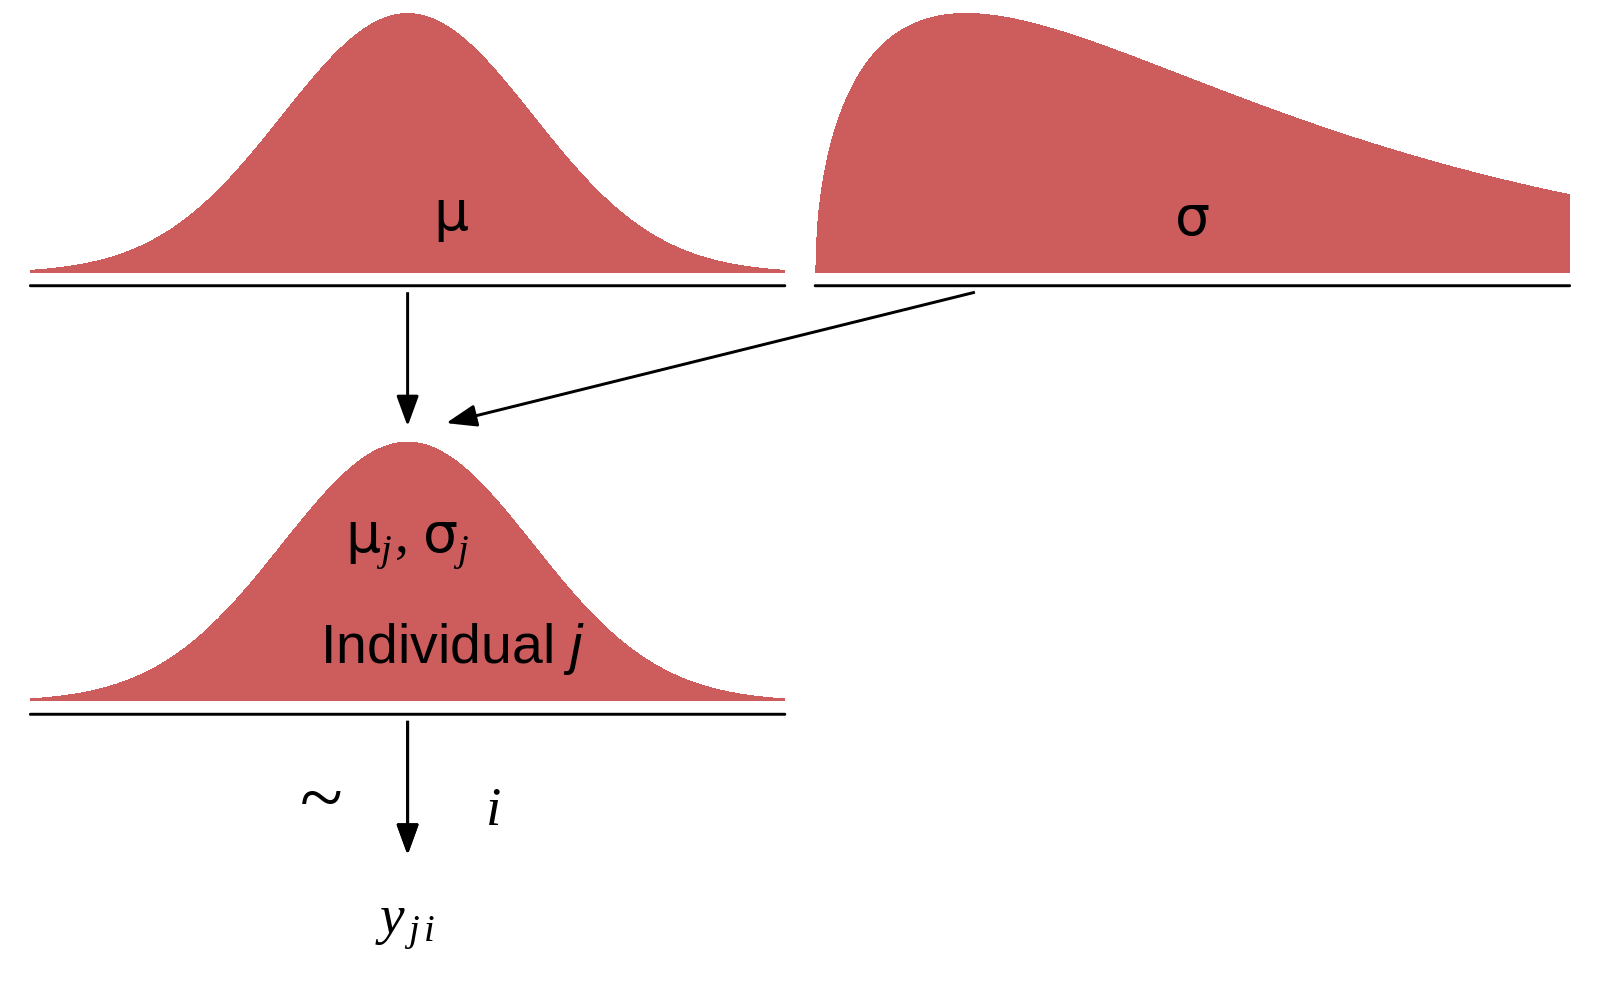

In [5]:
#code was directly inspired by S. Kurz, see https://solomonkurz.netlify.app/post/make-model-diagrams-kruschke-style/
(p1_1 + p1_2 + p2_1 + p2_2 + p3 + p4 + p5) + 
  plot_layout(design = layout) &
  ylim(0, 1)
theme_set(theme_grey())#Reset ggplot theme, 

## Let's create a data set with hierarchies

Imagine a WM task where we sampled $x$ WM scores by participant $\times$ condition (within design and repeated measure)

We want to create participants which present an inter-individual variability, therefore we define a distribution on the parameter $\mu$  so that each individual receives a unique $\mu$ parameter

The distribution we will sample from is given below : 

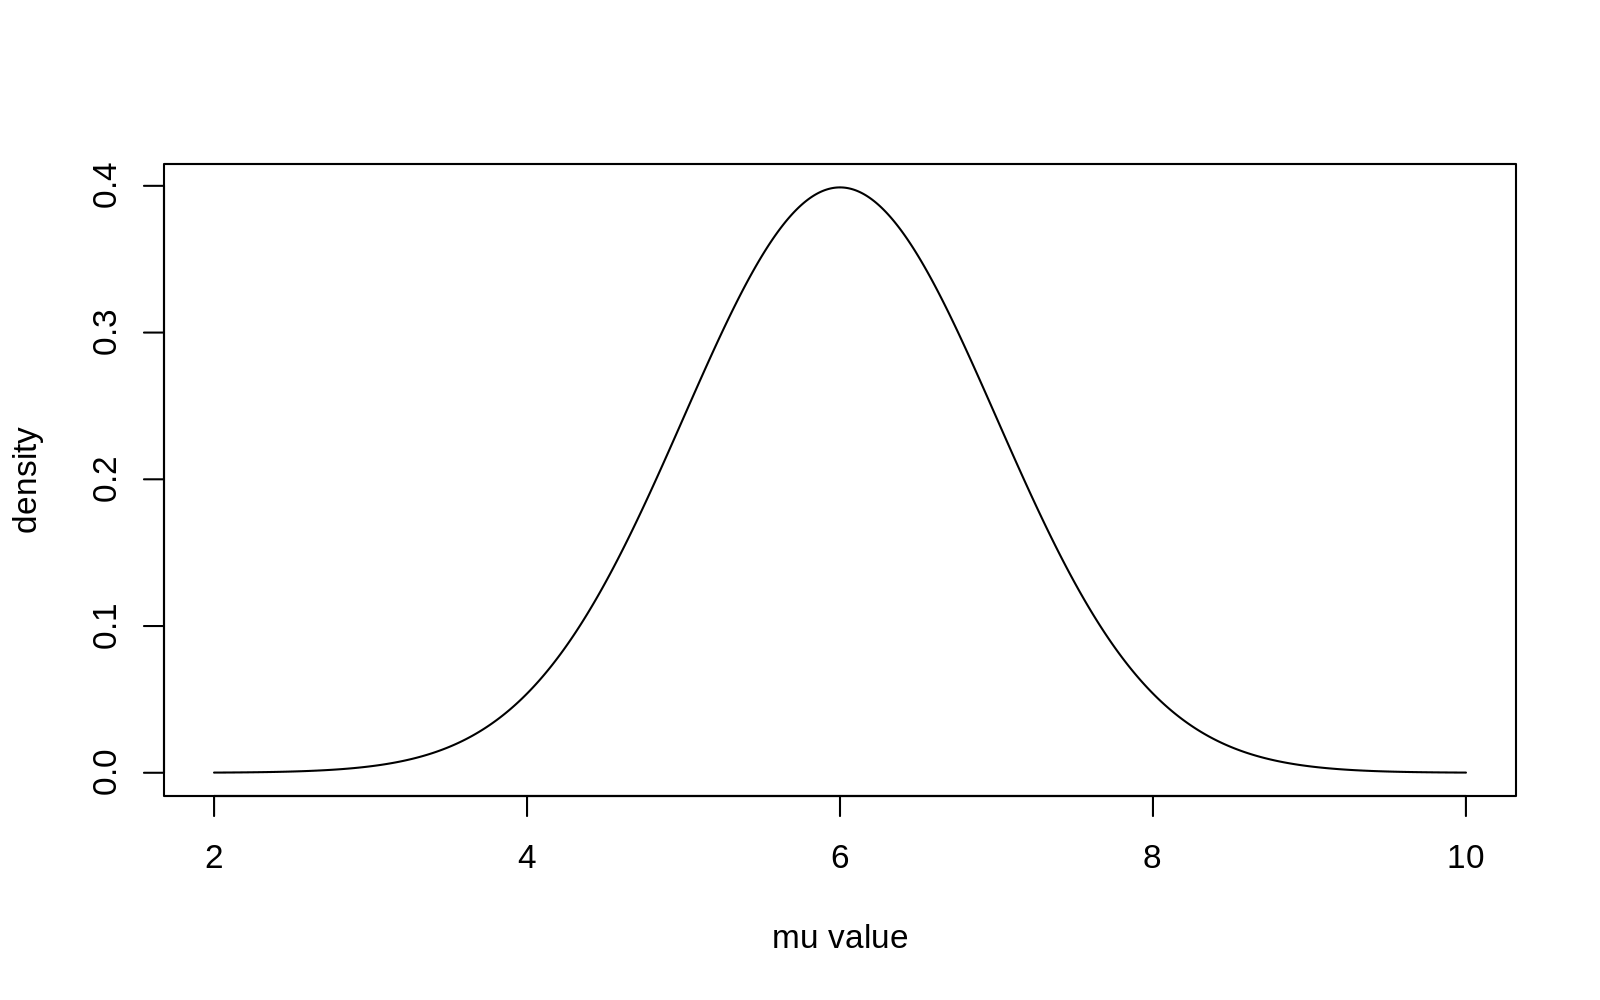

In [6]:
###### Distributions mu parameter
x = seq(2, 10, length=1000)
plot(x, dnorm(x, mean=6, sd=1), type="l", ylab="density", xlab="mu value")


Now we create a for loop were we generate up to 100 trials for 15 participants, each run draws random values for the $\mu$ parameter and a random number of trial (_e.g. a priori_ rejection criterion, fatigue,...)

In [7]:
mean_wm = 6
sd_wm = 1
set.seed(234)
n_participants = 15
data = data.frame()
ntrial_v = NULL
mu_v = NULL
for(i in 1:n_participants){
    ntrials = runif(1, 5, 100)# Ntrials from 5 to 100
    subdata = data.frame(trial=1:ntrials)#trial number vector
    mu = rnorm(1, mean=mean_wm, sd=sd_wm)#random sample from the normal illustrated above
    subdata$wm = rnorm(ntrials, mu, sd=sd_wm)#generating data based on the drawn mu
    subdata$participant = as.character(i) #recording participant
    data = rbind(data, subdata)#pasting the new subject to the df
    ntrial_v[i] <- ntrials#SAving the number of trials per participant
}

In [8]:
tail(data)

,trial,wm,participant
,<int>,<dbl>,<chr>
814,30,7.437569,15
815,31,7.642065,15
816,32,7.408912,15
817,33,9.127590,15
818,34,7.106579,15
819,35,7.074170,15


We can look at the n of trials we sampled

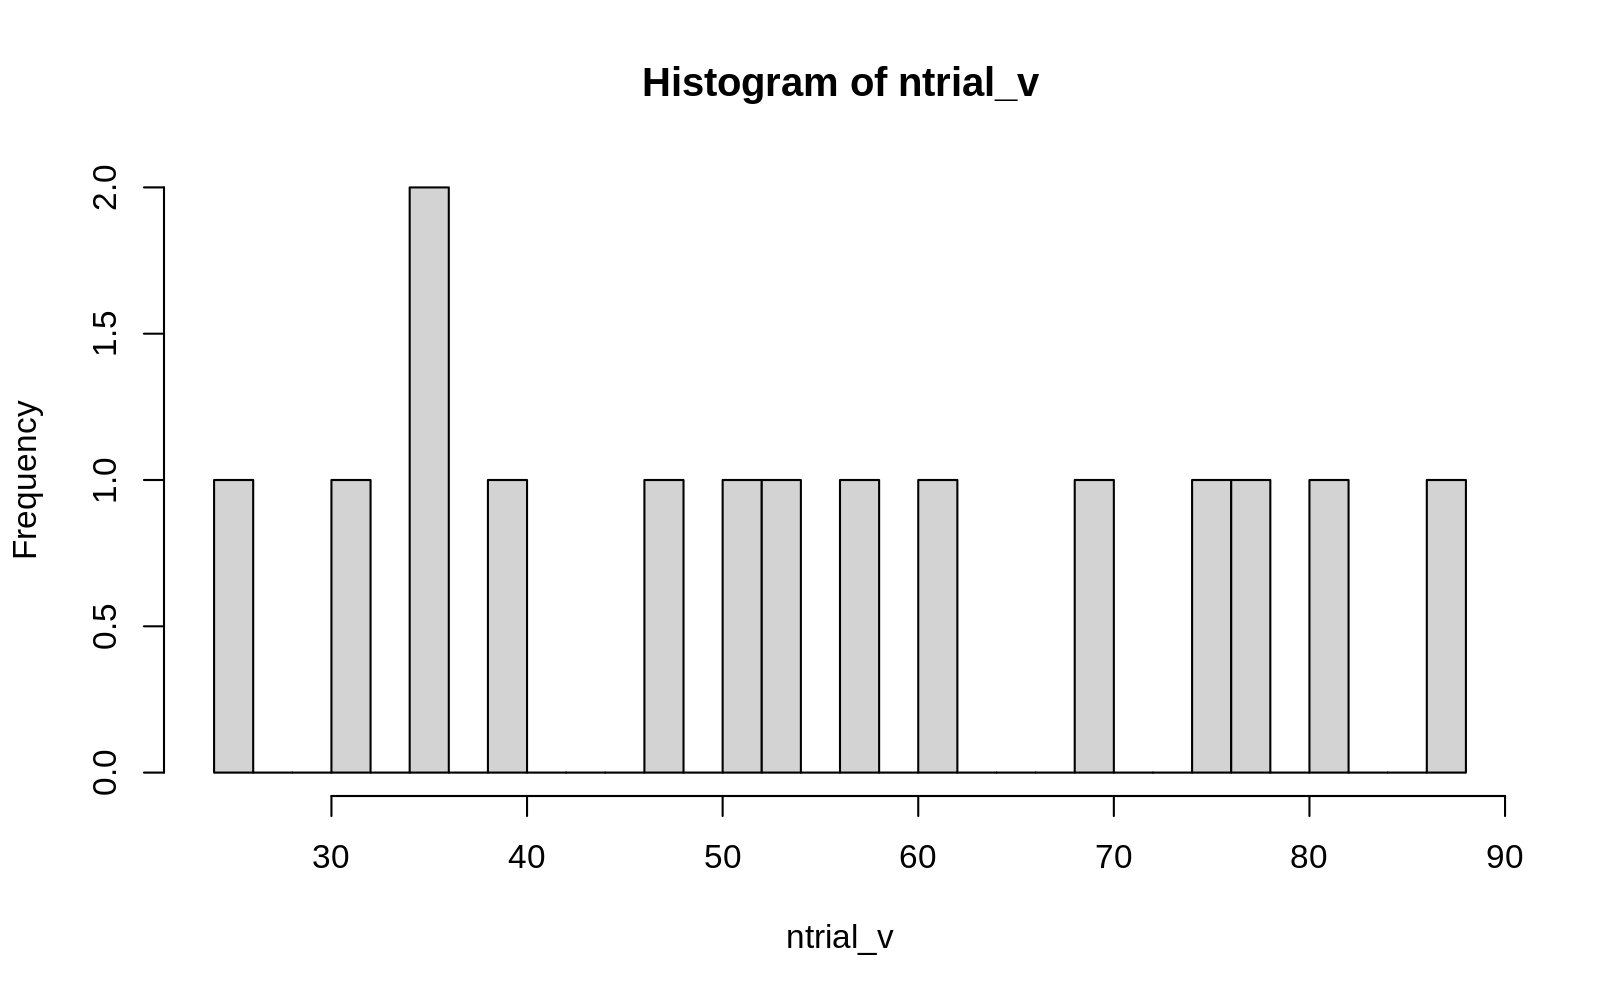

In [9]:
hist(ntrial_v,breaks=30)

We can take a look at the distribution of WM for all the participants

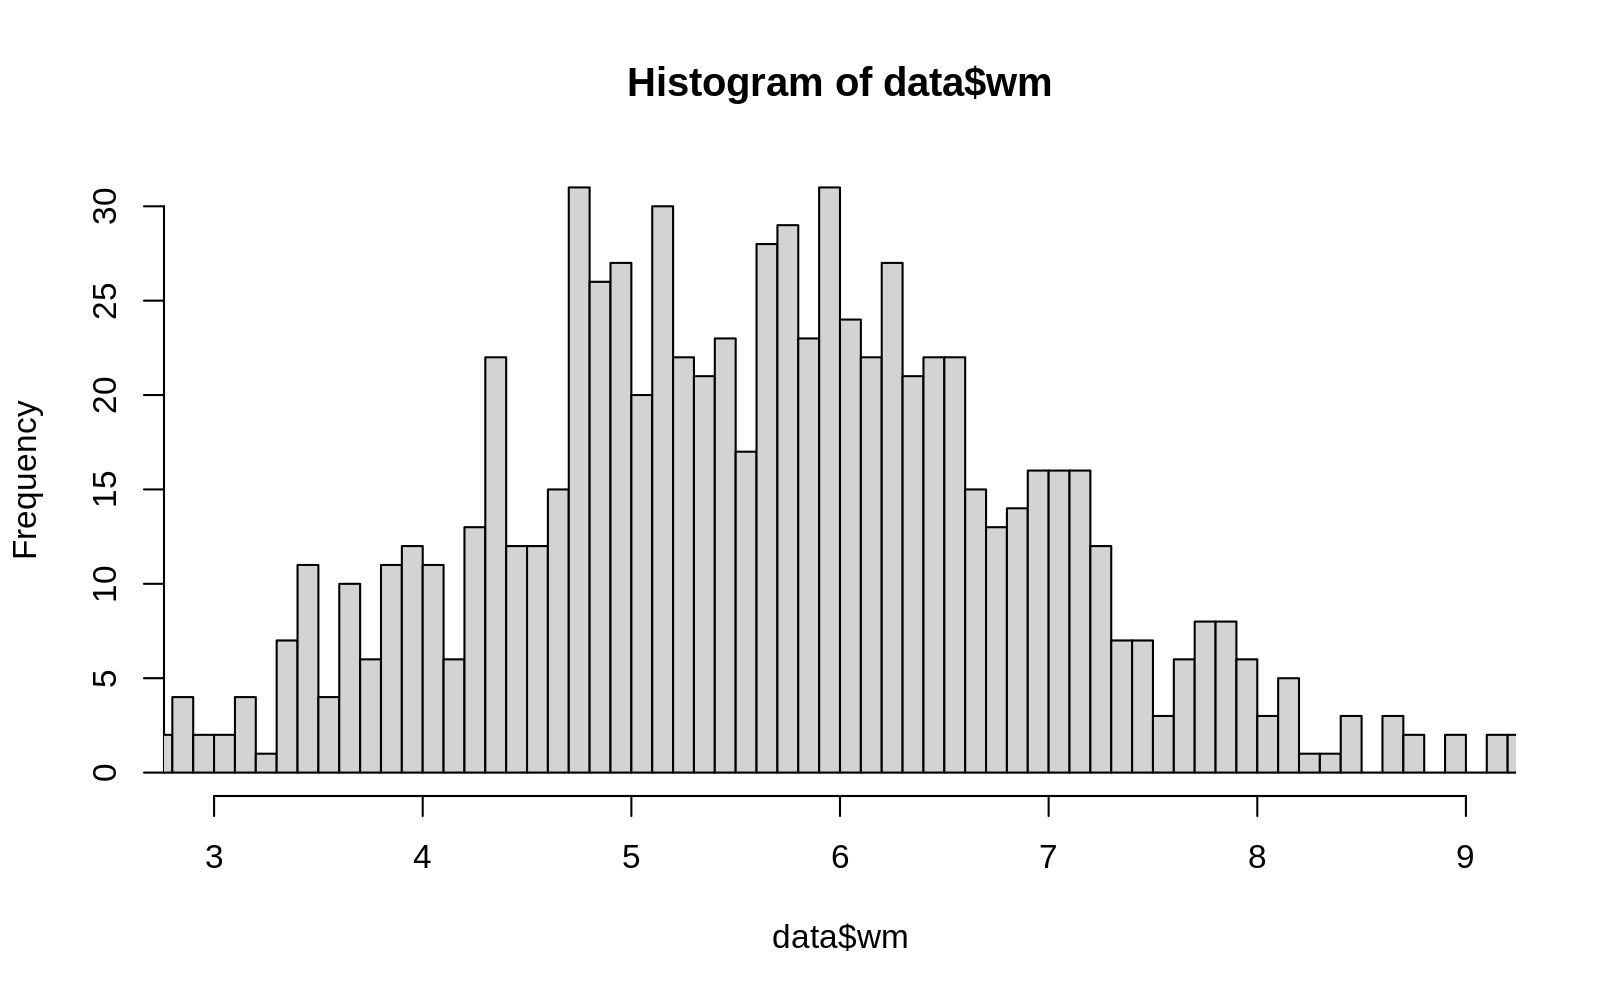

In [10]:
hist(data$wm, breaks=100, xlim=c(3,9))

or for each participant

Loading required package: lattice



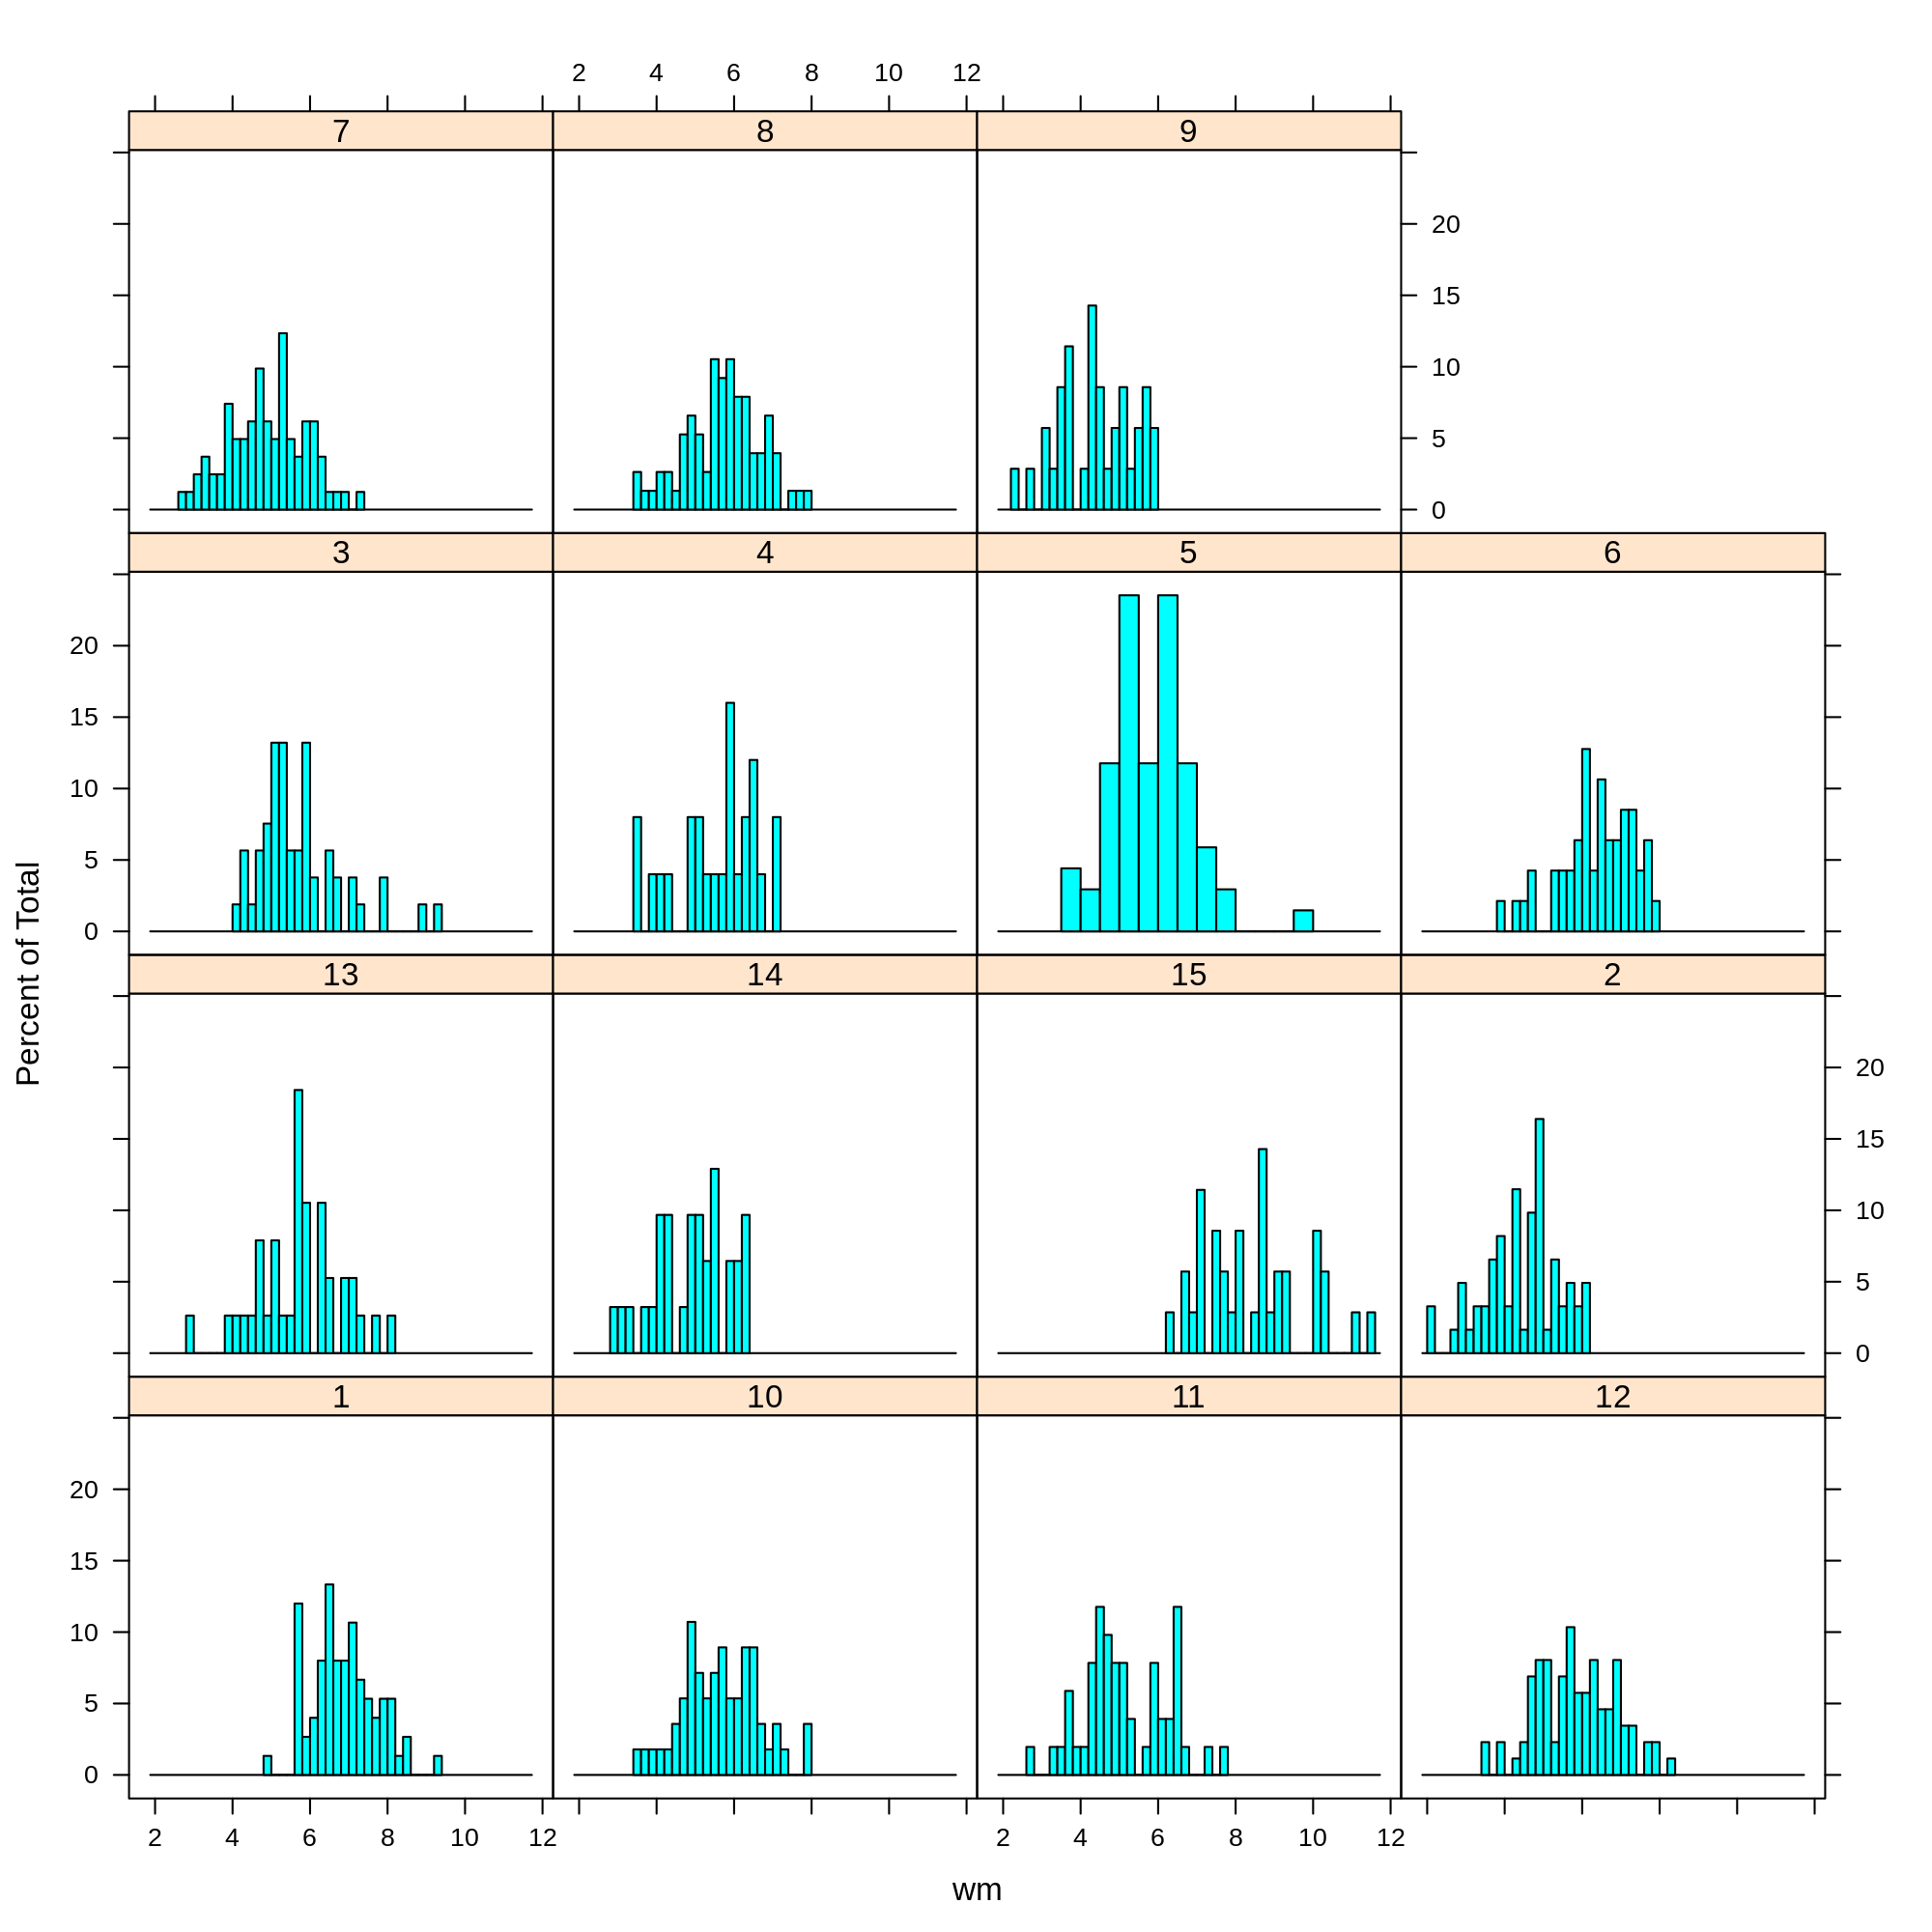

In [11]:
require(lattice)#needed for histogram plot
options(repr.plot.width=10, repr.plot.height=10)
histogram( ~ wm | participant ,data = data, breaks=20) 
options(repr.plot.width=8, repr.plot.height=5, repr.plot.res = 200)

## Adding experimental levels

We will now add an experimental condition, e.g. imagine we have a perfect longitudinal study on age and working memory, we tested each individual again at different ages

In [12]:
library(MASS)#we will sample from a multivariate normal distribution
data = data.frame()
varcovmat = matrix(c(1, 0, 0, 1), nrow=2)#See later for var-cov matrix
data = data.frame()
for(i in 1:n_participants){
    re = mvrnorm(n=1, mu=c(0, 0), Sigma=varcovmat)#Sampling from the mvn, rescaling according to DV distribution in next lines
    mu_i = re[1] * sd_wm + mean_wm#participant keeps the same mu during all the years
    b_age = re[2] *(sd_wm*2) - (sd_wm*4) ##Each participant get a single slope for age, the effect size is displayed as a unit of sd_wm
    age_tested = runif(runif(1, 5,15), 1, 99)#retesting participant at different random [1,99] ages [5,15] times
    for (age in age_tested){# A for loop in a for loop is especially dirty but more transparent
        age = age/100#We recode age for scale purpose
        ntrials = runif(1, 5, 100)
        subdata = data.frame(trial=1:ntrials)
        mu = mu_i+b_age*age#inducing age diff alpha + beta * IV
        subdata$wm = rnorm(ntrials, mu, sd=sd_wm)
        subdata$participant = as.character(i)
        subdata$age = age #storing age
        data = rbind(data, subdata)
    }
    
}


Attaching package: ‘MASS’


The following object is masked from ‘package:patchwork’:

    area


The following object is masked from ‘package:dplyr’:

    select




For a starter we are going to pre-average the data

In [13]:
means_bysub = aggregate(data$wm, FUN=mean, 
          by=list(age=data$age, participant = data$participant))

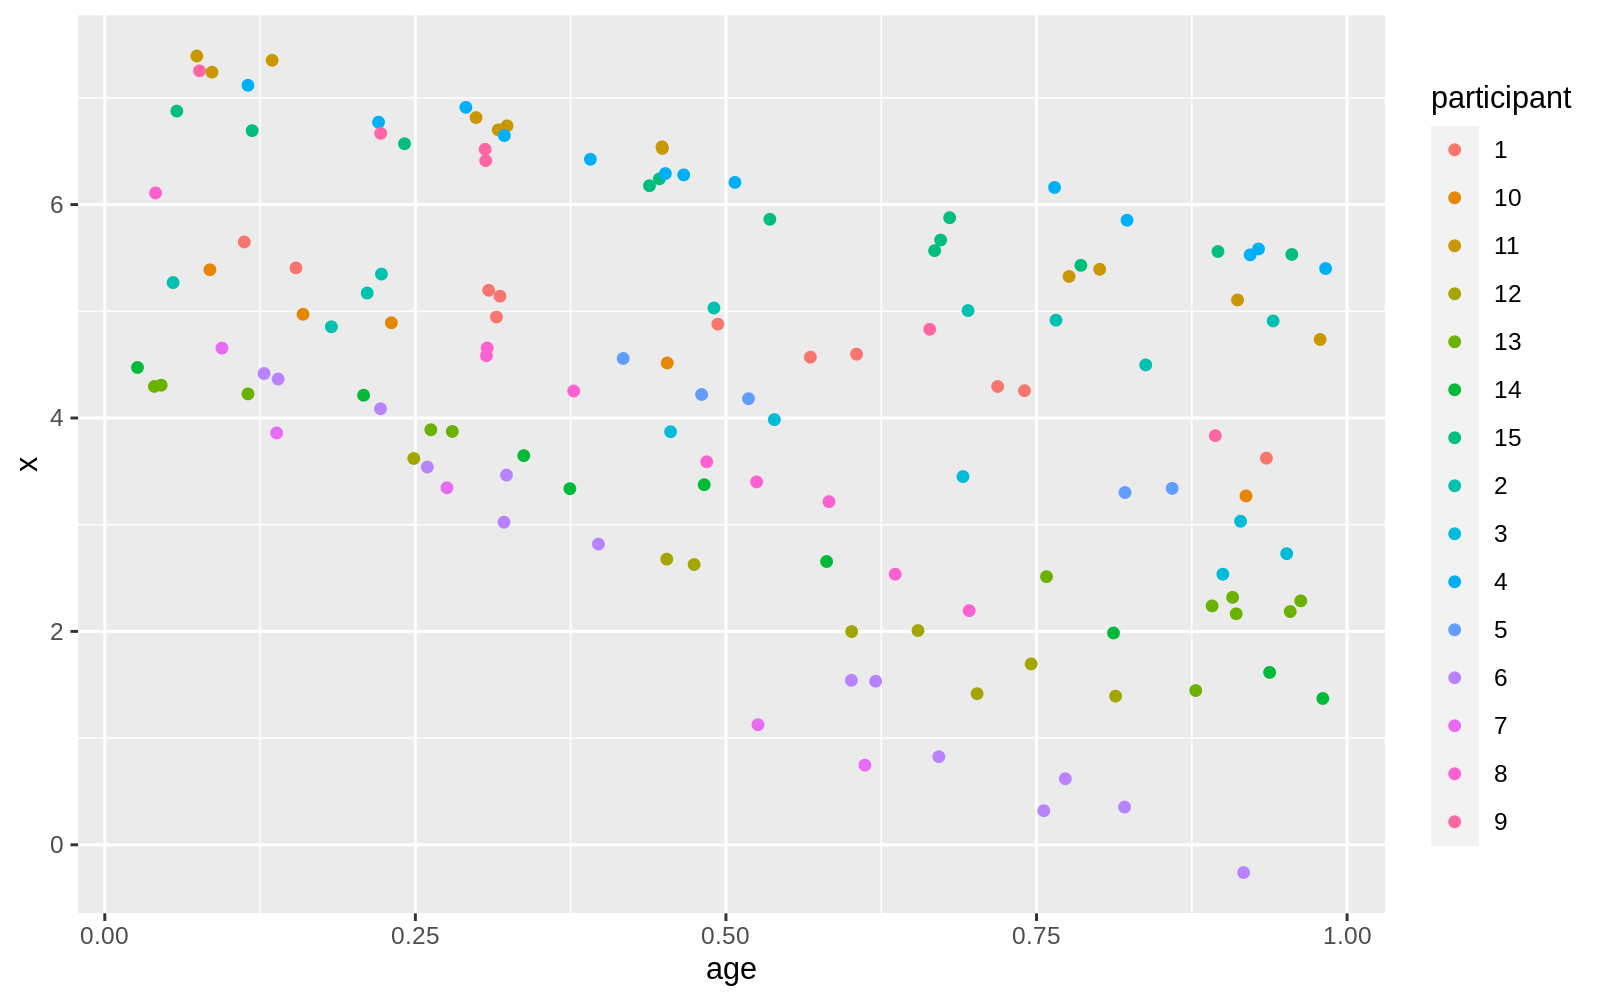

In [14]:
library(ggplot2)
ggplot() +
  geom_point(data=means_bysub, aes(x=age, y=x, group = participant, colour = participant)) + 
  scale_colour_discrete('participant') 

A simple LM :

In [15]:
m0 <- lm(x ~ age, data = means_bysub)#Syntax discussed later
means_bysub$random.intercept.preds <- predict(m0)

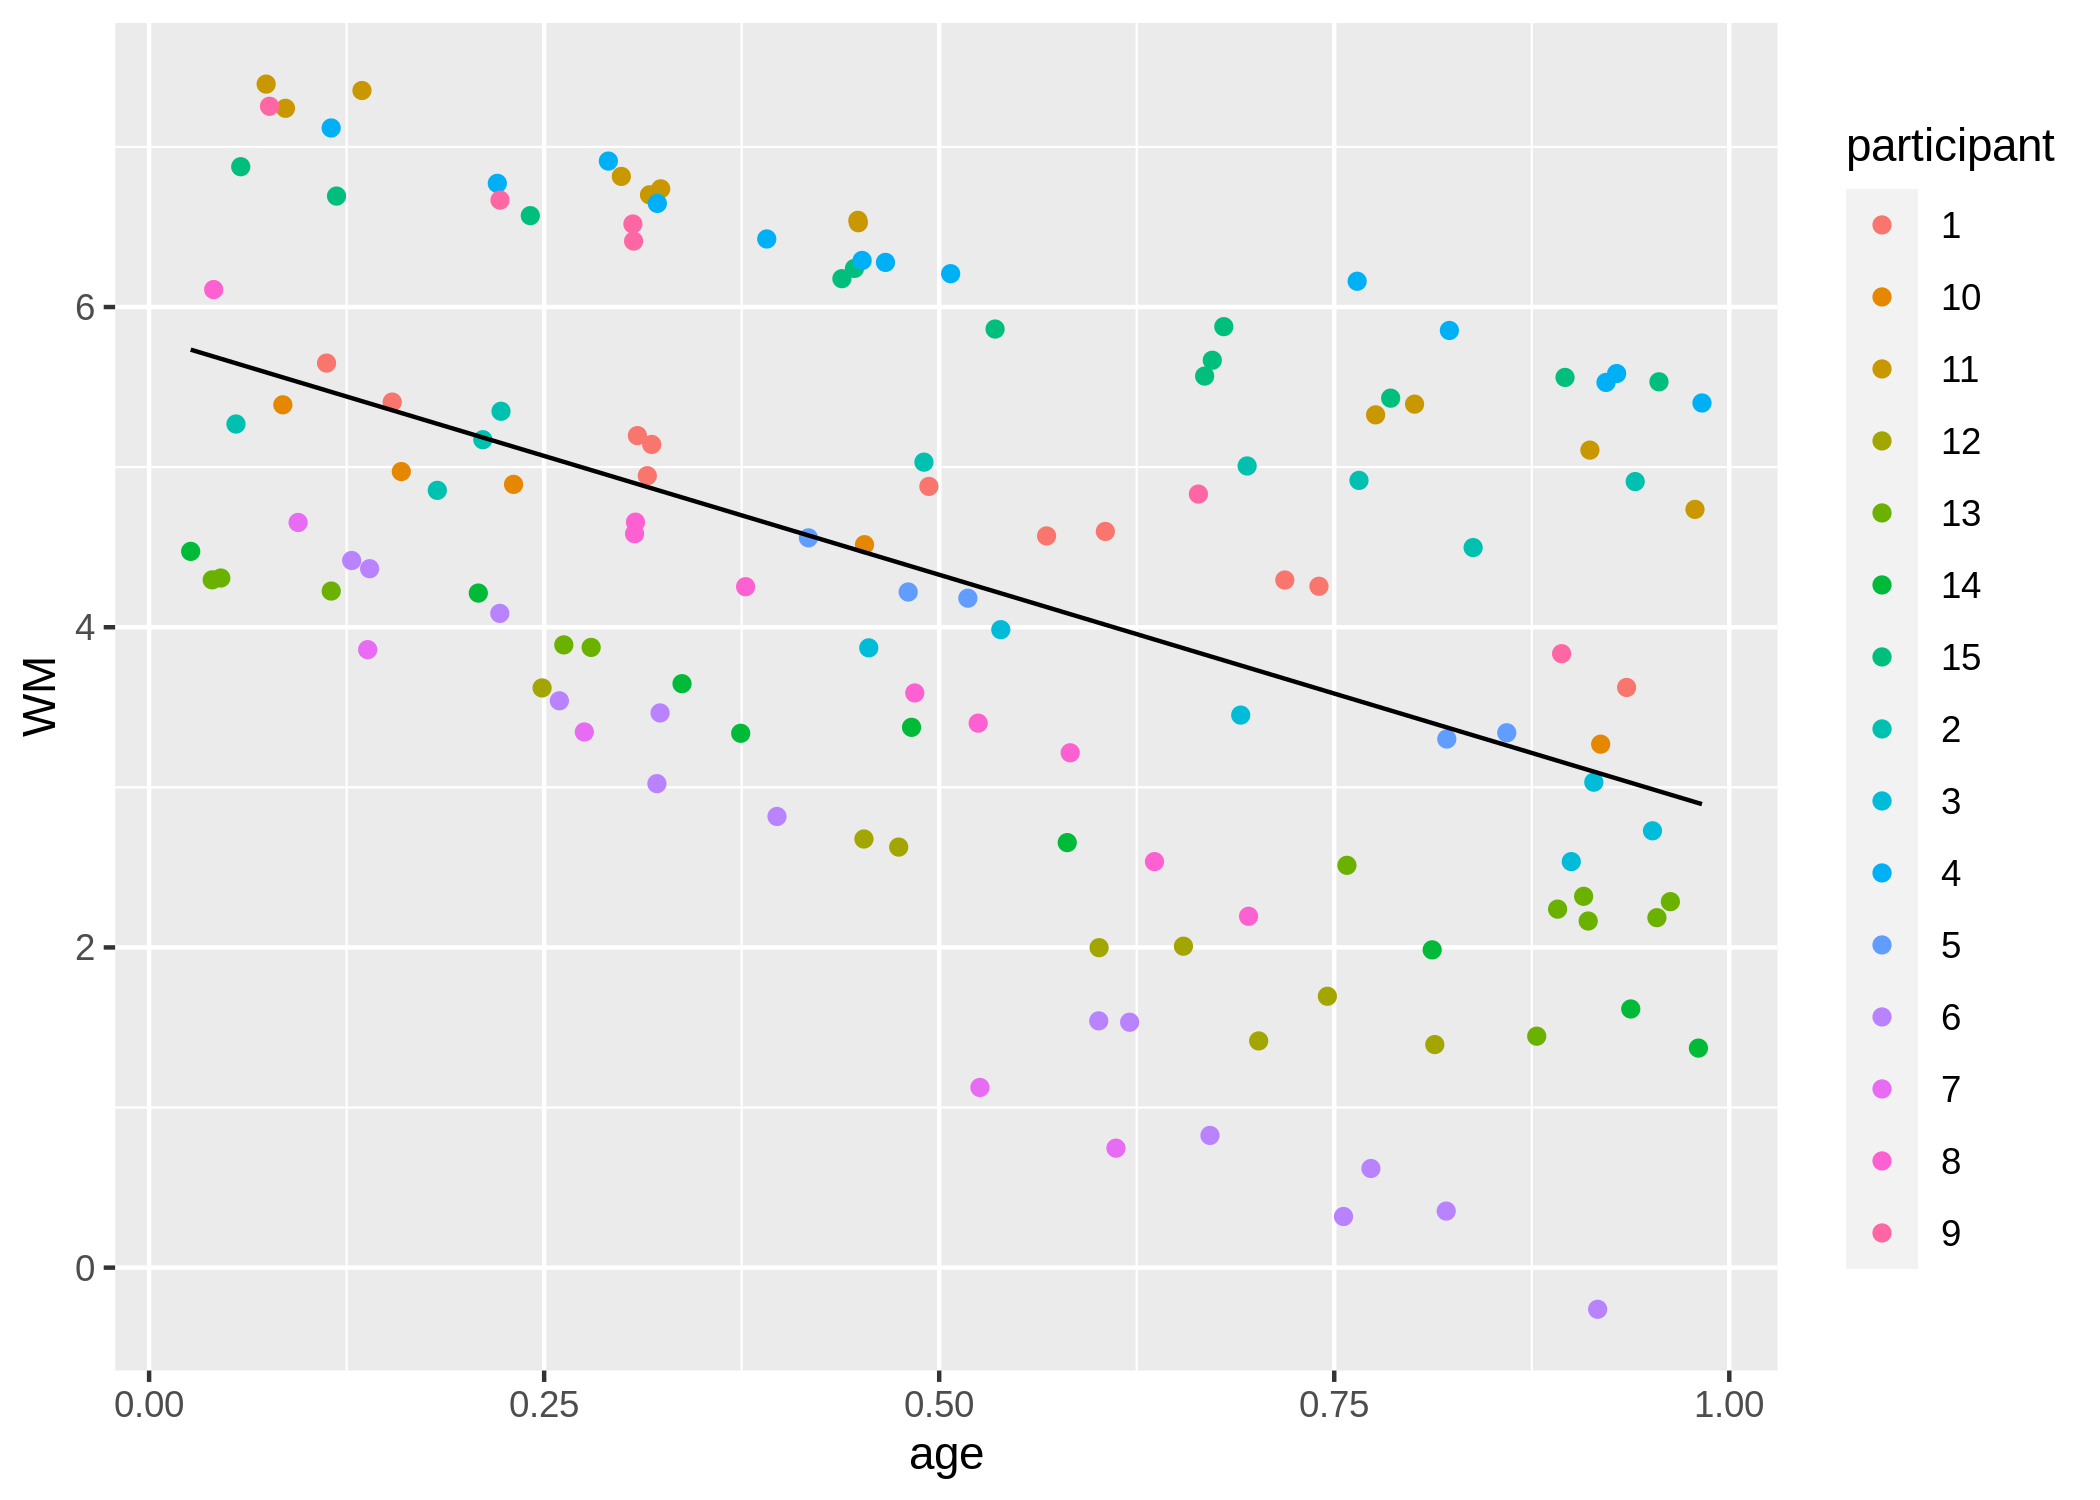

In [16]:
options(repr.plot.width=7, repr.plot.height=5, repr.plot.res = 300)
ggplot() +
  geom_point(data=means_bysub, aes(x=age, y=x, group = participant, colour = participant)) + 
  geom_line(data=means_bysub, aes(x=age, y=random.intercept.preds)) +
  labs(x="age", y="WM") +
  scale_colour_discrete('participant') 

To respect assumptions of LM we need _i.i.d._ data : 
- We could fit on lm() per participant -> unefficient and how do we perform the second step about population effect ?
- We can fit linear mixed models

# Formalism behind LMM

Mixed models are said mixed because they include fixed effects and random effects (confusing terminology: multilevel, hierarchical, random,...)

- Fixed = our effects of interest (_e.g._ age)
- Random = an effect (_e.g._ inter-individual variations) not in the scope of our research question

LMM are extensions of LM :

$y_{ji} \sim \mathcal{N}(\mu_j, \sigma)$

But this time : 

$\mu_j = \alpha_j + \beta_j IV$


$\alpha_j \sim \mathcal{N}(\mu_\alpha, \sigma_\alpha)$

$\beta_j \sim \mathcal{N}(\mu_\beta, \sigma_\beta)$

As in module 1, adding predictors just increase the number of $\beta_j$

$\alpha_j \sim \mathcal{N}(\mu_\alpha, \sigma_\alpha)$

$\beta_j \sim \mathcal{N}(\mu_\beta, \sigma_\beta)$

As in module 1, adding predictors just increase the number of $\beta_j$

In [17]:
mu_j = rnorm(1, mean=mean_wm, sd=sd_wm)#Random intercept a_j

In [18]:
b_age_j = rnorm(1, -4, 2)#Random slope

## Illustrating the concept  of random effects

We are now going to use (one of) the R package allowing to fit mixed models : lme4 


In [19]:
#install.packages(lme4)
library(lme4)

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack




Next we illustrate the notion of random intercept vs random slopes vs full random effects (R code used was largely inspired by : http://mfviz.com/hierarchical-models/ )

### A model with random effects on the intercept ($\alpha_j$)

In [20]:
m1 <- lmer(x ~ age + (1|participant), data = means_bysub)#Syntax
means_bysub$random.intercept.preds <- predict(m1)

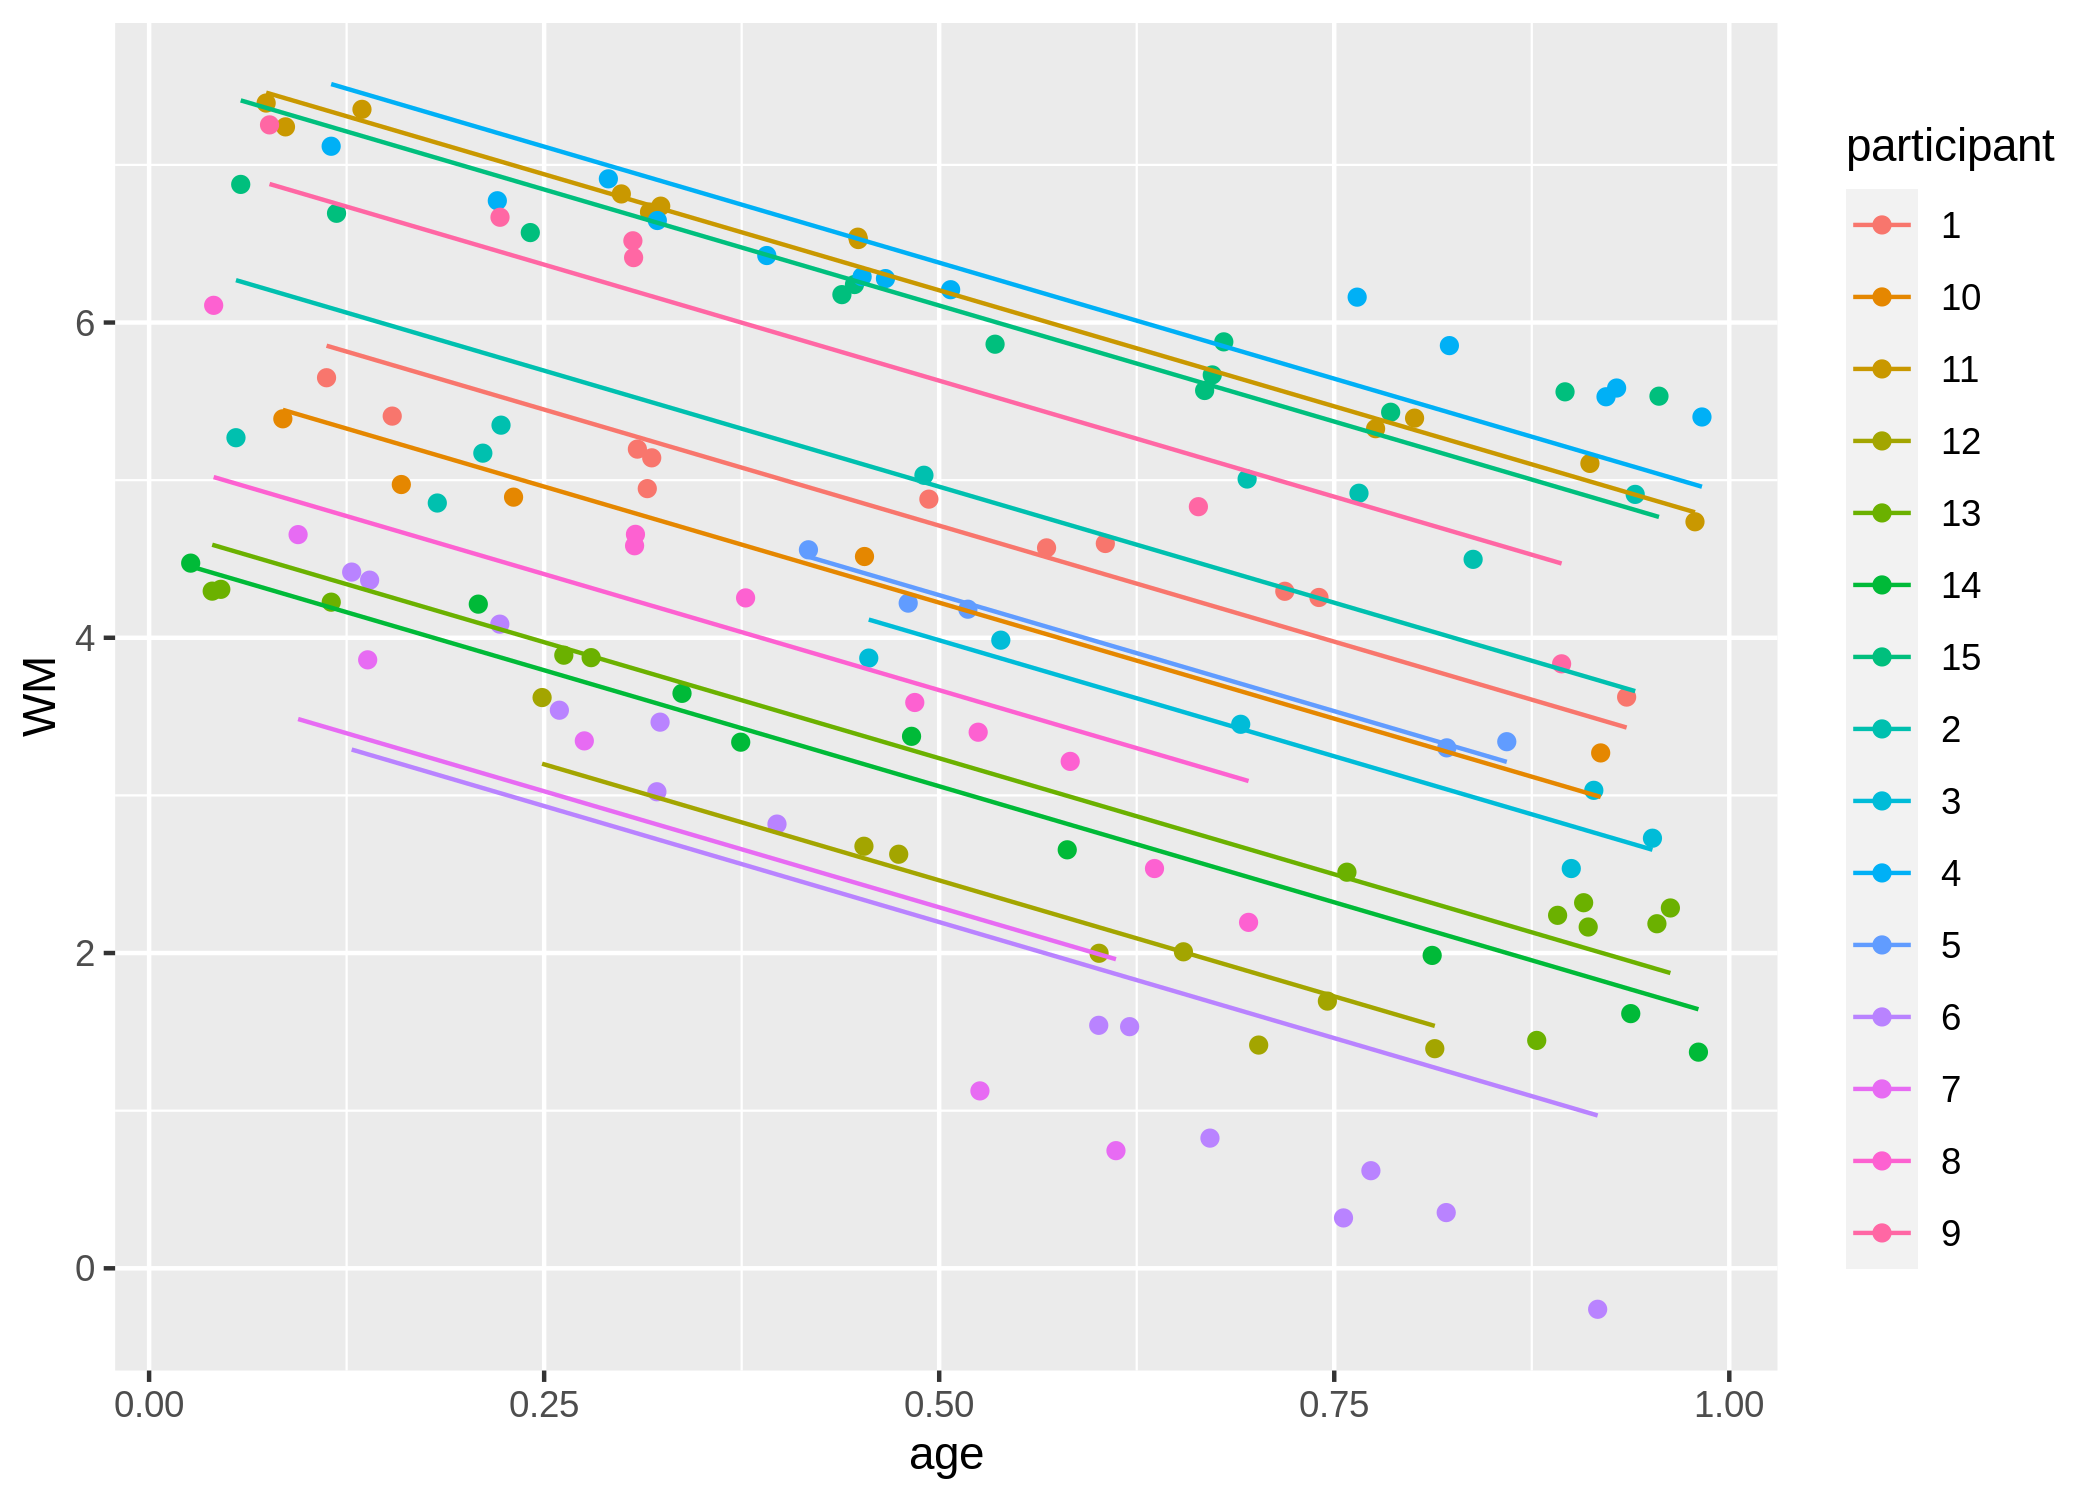

In [21]:
library(ggplot2)
options(repr.plot.width=7, repr.plot.height=5, repr.plot.res = 300)
ggplot() +
  geom_point(data=means_bysub, aes(x=age, y=x, group = participant, colour = participant)) + 
  geom_line(data=means_bysub, aes(x=age, y=random.intercept.preds, group = participant, colour = participant)) +
  labs(x="age", y="WM") +
  scale_colour_discrete('participant') 

### A model with random effects on the slope ($\beta_j$)

In [22]:
m2 <- lmer(x ~ age + (0+age|participant), data = means_bysub)
means_bysub$random.intercept.preds <- predict(m2)

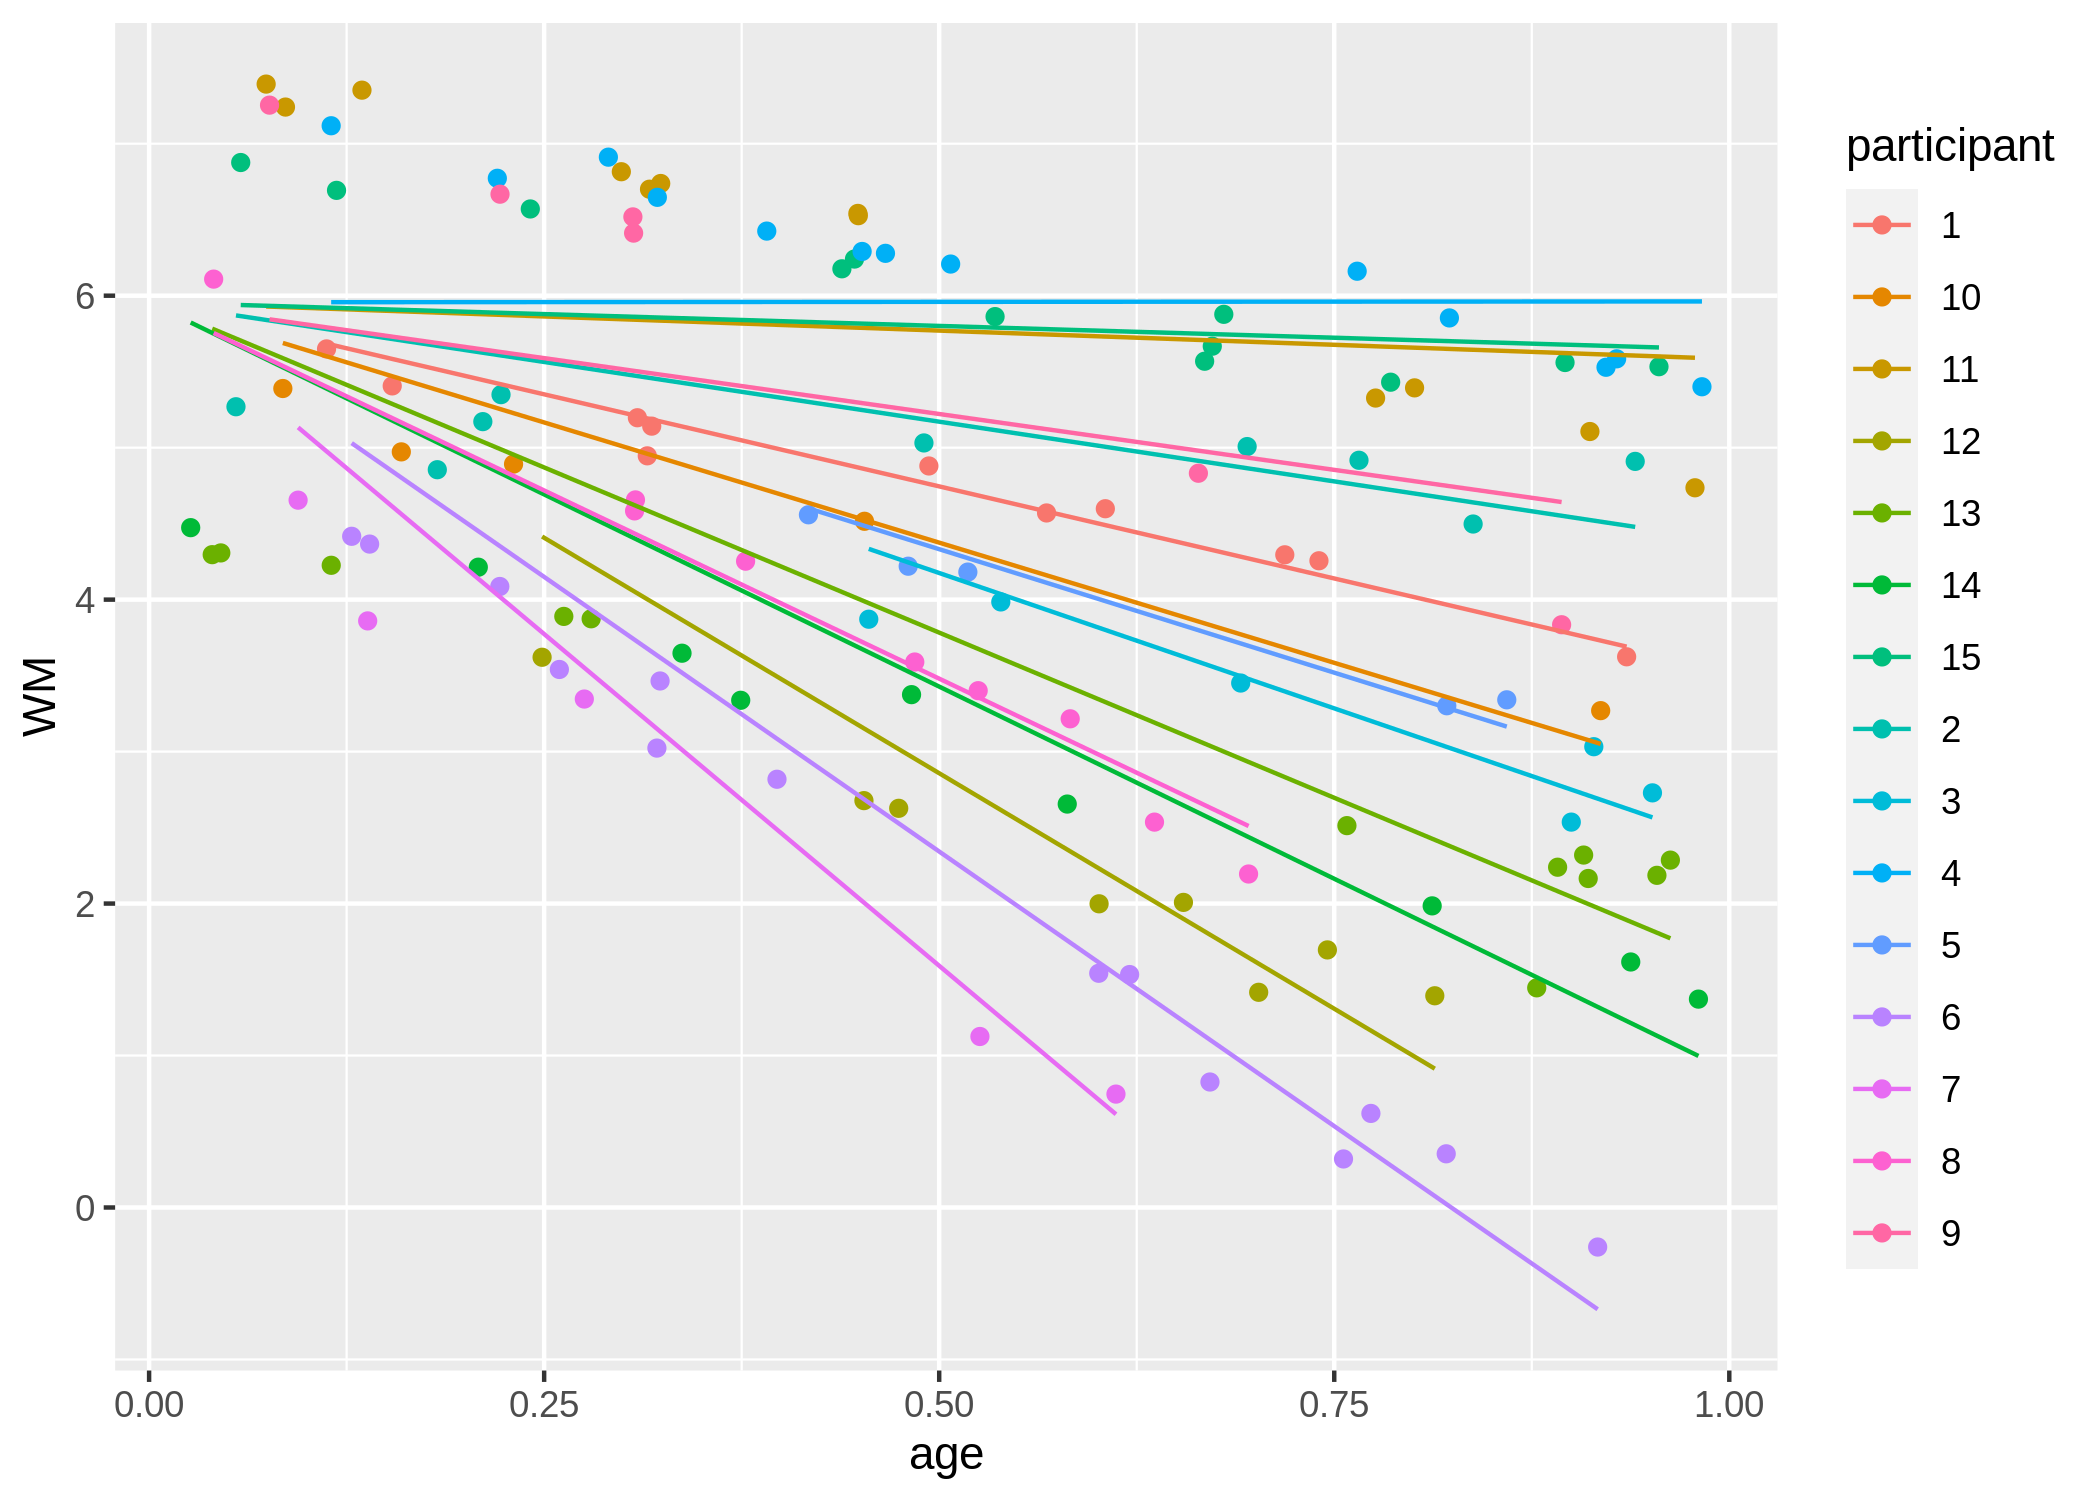

In [23]:
options(repr.plot.width=7, repr.plot.height=5, repr.plot.res = 300)
ggplot() +
  geom_point(data=means_bysub, aes(x=age, y=x, group = participant, colour = participant)) + 
  geom_line(data=means_bysub, aes(x=age, y=random.intercept.preds, group = participant, colour = participant)) +
  labs(x="age", y="WM") +
  scale_colour_discrete('participant') 

### A model with random effects on the intercept and on the slope ($\alpha_j$ and $\beta_j$)

In [24]:
m3 <- lmer(x ~ age + (age||participant), data = means_bysub)#1+ is implicit, 0+ explicitely removes intercept
#In this model I specified || which removes the estimation of the correlation between intercept and slope, more later
means_bysub$random.intercept.preds <- predict(m3)

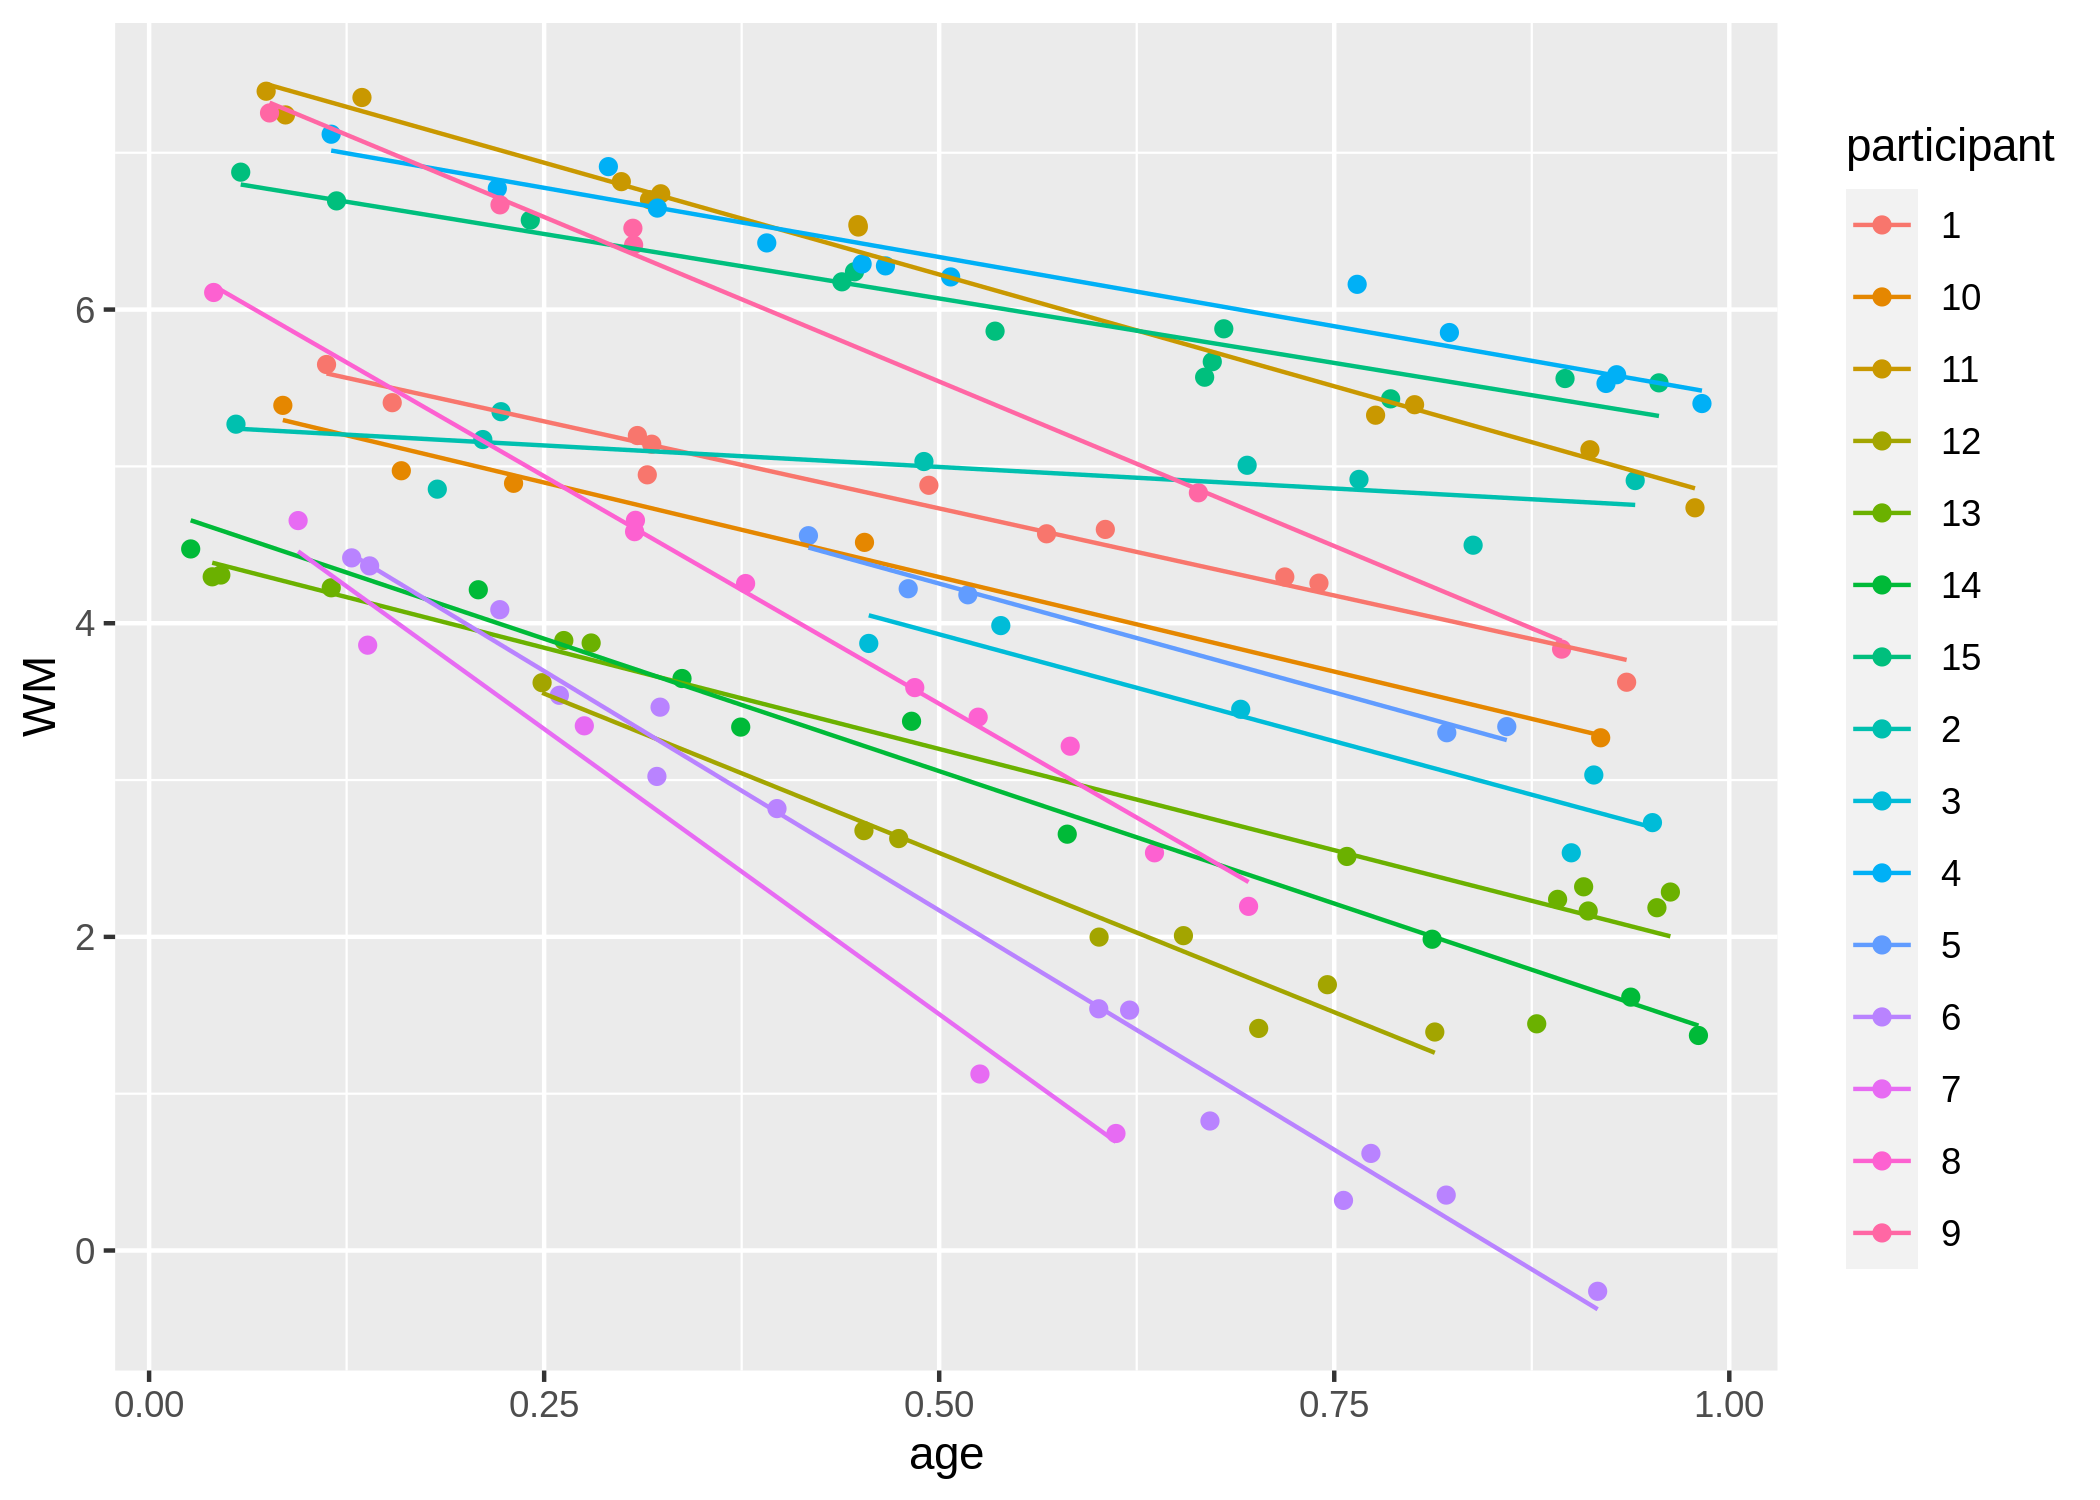

In [25]:
options(repr.plot.width=7, repr.plot.height=5, repr.plot.res = 300)
ggplot() +
  geom_point(data=means_bysub, aes(x=age, y=x, group = participant, colour = participant)) + 
  geom_line(data=means_bysub, aes(x=age, y=random.intercept.preds, group = participant, colour = participant)) +
  labs(x="age", y="WM") +
  scale_colour_discrete('participant') 

# Illustrating shrinkage

We will compare parameter estimate from one lm() / participant vs the partial pooling operated by LMMs

In [26]:
i_slope_values = NULL
i_intercept_values = NULL
for(i in 1:length(unique(means_bysub$participant))){
    m0_ = lm(x ~ age, data = means_bysub[means_bysub$participant == i,])
    i_slope_values[i] = m0_$coefficients["age"]
    i_intercept_values[i] = m0_$coefficients["(Intercept)"]
}


In [27]:
h_slope_values = coef(m3)$participant$age
h_intercept_values = coef(m3)$participant$'(Intercept)'

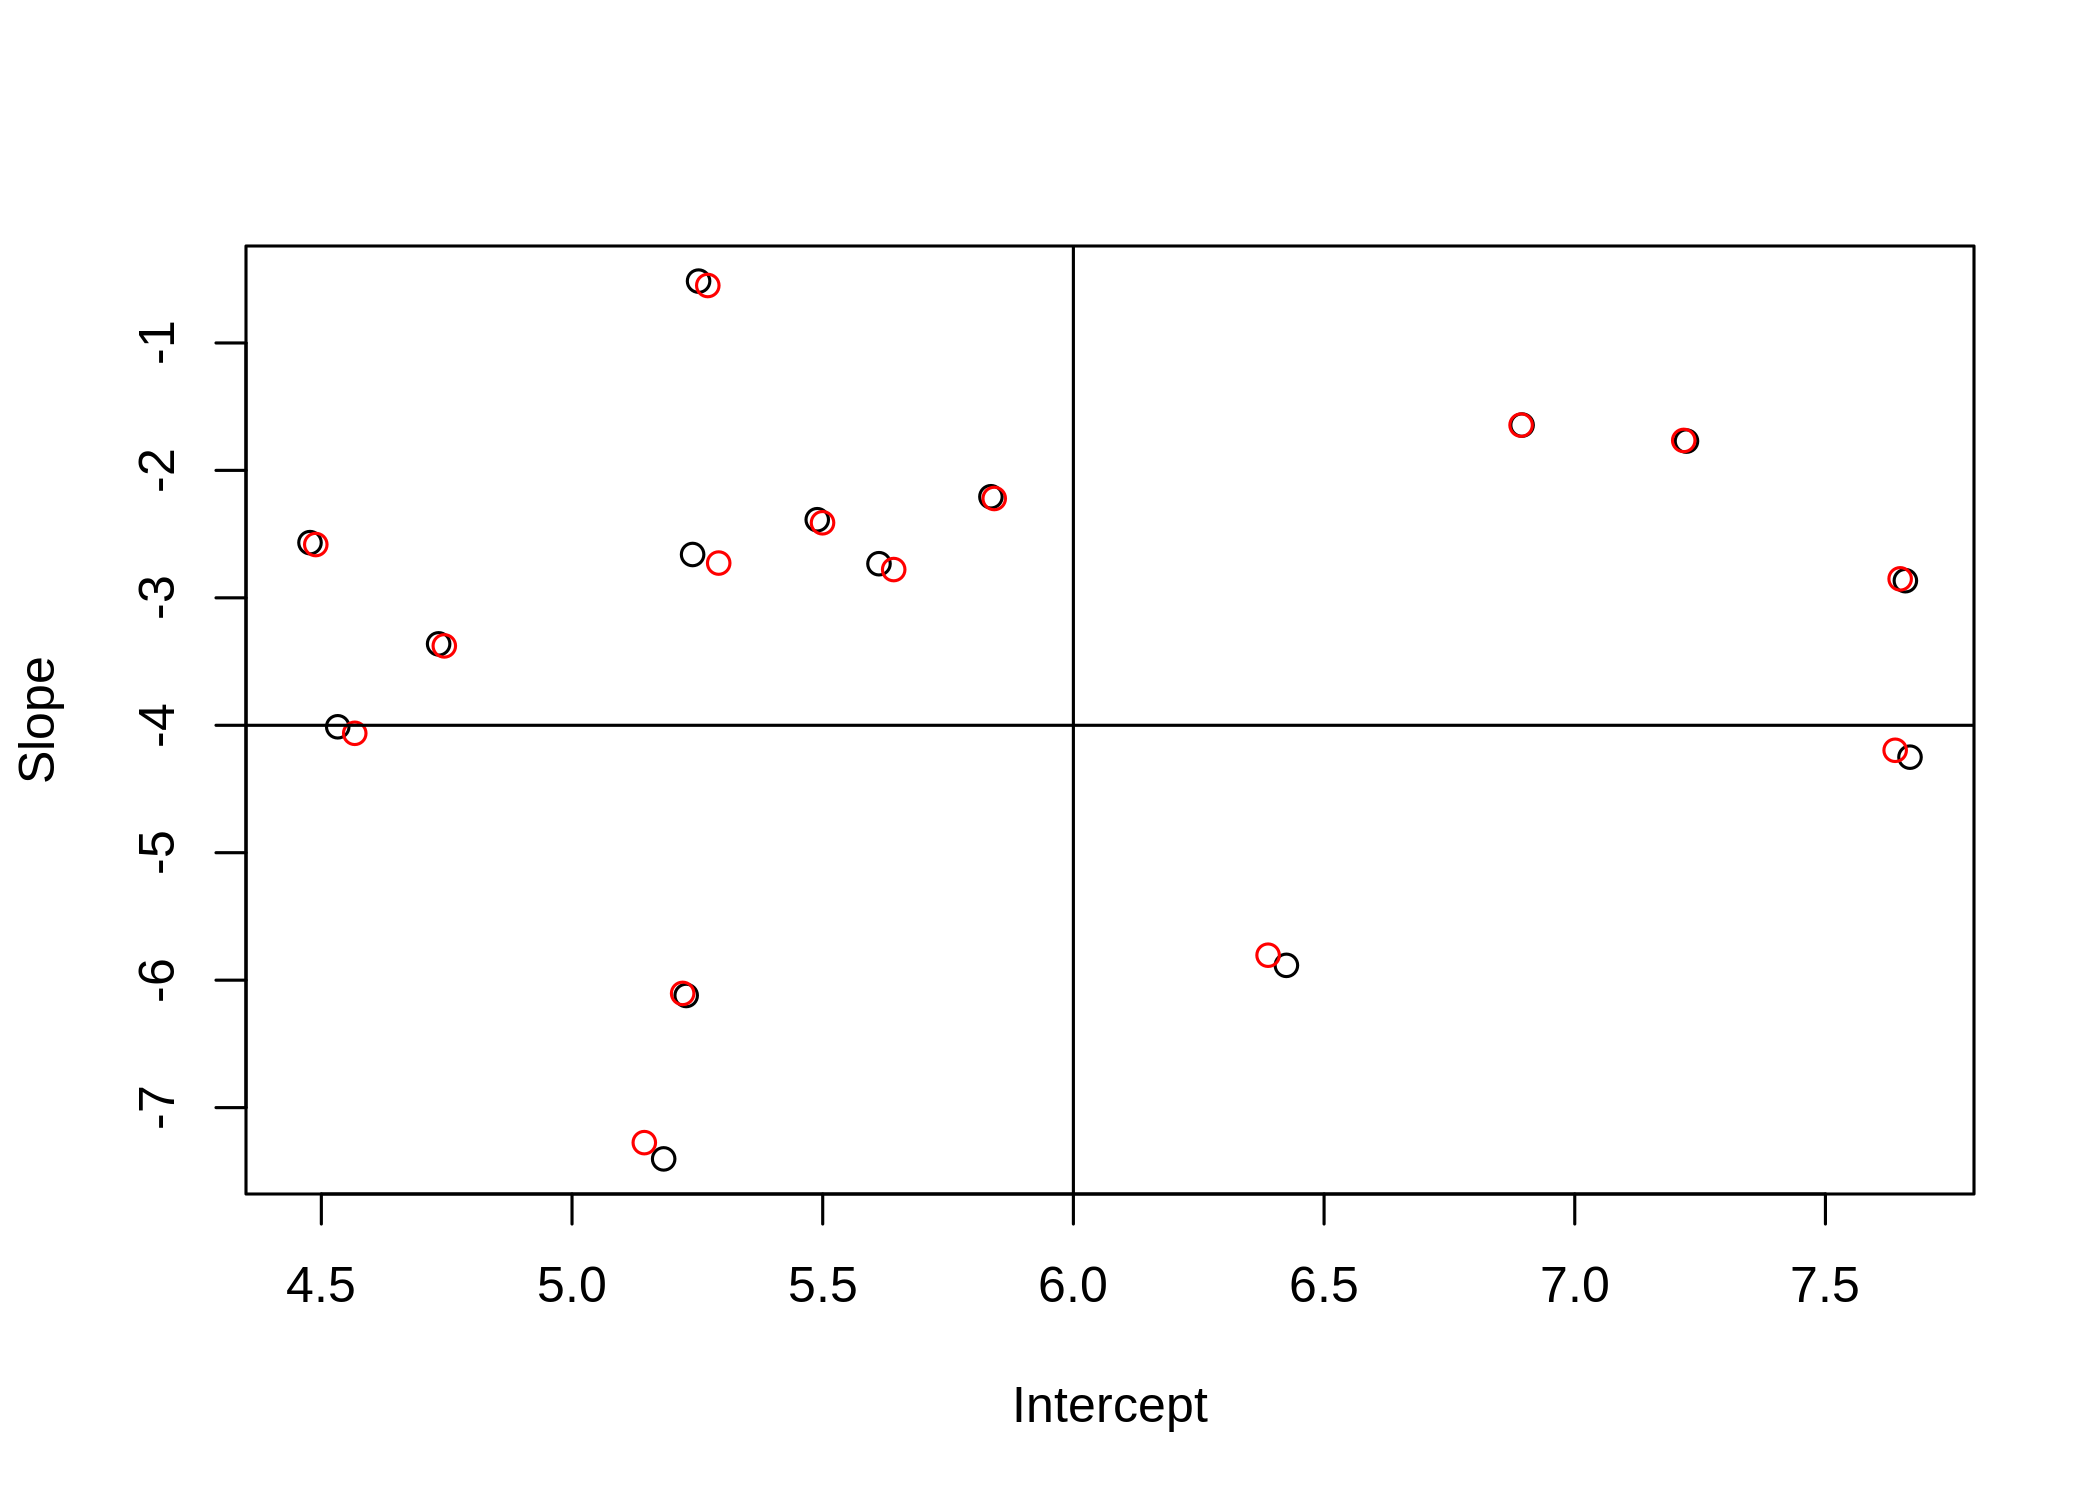

In [28]:
plot(i_intercept_values, i_slope_values, xlab="Intercept", ylab="Slope")#parameter of individual LM
points(h_intercept_values, h_slope_values, col="red")#FE parameters of LMM
abline(v=6)#True intercept
abline(h=-4)#True slope


To go further on the notion of pooling (one LM), _vs._ partial pooling (LMM) _vs._ no-pooling (one LM / participant) see the blog post by [T.Mahr](https://www.tjmahr.com/plotting-partial-pooling-in-mixed-effects-models/)

# Inspecting and comparing the outputs

In [29]:
summary(m0)


Call:
lm(formula = x ~ age, data = means_bysub)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.3510 -1.2478 -0.0826  1.6419  2.6184 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   5.8117     0.2766  21.012  < 2e-16 ***
age          -2.9681     0.4701  -6.313 3.72e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.576 on 134 degrees of freedom
Multiple R-squared:  0.2292,	Adjusted R-squared:  0.2235 
F-statistic: 39.86 on 1 and 134 DF,  p-value: 3.72e-09


In [30]:
summary(m1)

Linear mixed model fit by REML ['lmerMod']
Formula: x ~ age + (1 | participant)
   Data: means_bysub

REML criterion at convergence: 261.1

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.46308 -0.47152 -0.00825  0.53307  2.50096 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept) 2.0696   1.4386  
 Residual                0.2491   0.4991  
Number of obs: 136, groups:  participant, 15

Fixed effects:
            Estimate Std. Error t value
(Intercept)   5.6974     0.3825   14.90
age          -2.9445     0.1553  -18.96

Correlation of Fixed Effects:
    (Intr)
age -0.207

In [31]:
summary(m2)

Linear mixed model fit by REML ['lmerMod']
Formula: x ~ age + (0 + age | participant)
   Data: means_bysub

REML criterion at convergence: 306.2

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.48144 -0.50664 -0.07217  0.53755  2.44197 

Random effects:
 Groups      Name Variance Std.Dev.
 participant age  6.9532   2.6369  
 Residual         0.3591   0.5993  
Number of obs: 136, groups:  participant, 15

Fixed effects:
            Estimate Std. Error t value
(Intercept)   5.9566     0.1078  55.265
age          -3.5092     0.7085  -4.953

Correlation of Fixed Effects:
    (Intr)
age -0.237

In [32]:
summary(m3)

Linear mixed model fit by REML ['lmerMod']
Formula: x ~ age + ((1 | participant) + (0 + age | participant))
   Data: means_bysub

REML criterion at convergence: 52.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.5813 -0.5184  0.1037  0.5889  1.7286 

Random effects:
 Groups        Name        Variance Std.Dev.
 participant   (Intercept) 1.1721   1.0826  
 participant.1 age         3.4357   1.8536  
 Residual                  0.0287   0.1694  
Number of obs: 136, groups:  participant, 15

Fixed effects:
            Estimate Std. Error t value
(Intercept)   5.8333     0.2822  20.672
age          -3.3565     0.4831  -6.947

Correlation of Fixed Effects:
    (Intr)
age -0.017

## "Significance" testing

When focusing on significance testing (but also when focus is on estimation) you should carefully think about the contrast you used for your factors (cf. module 1).

_e.g._ :
- how could my intercept make sense in a significance testing framework ?
- Am I interested in the difference between two levels (sum-coding, \[-0.5, 0.5\]) ? Or how moving from one standard condition to the other changes the intercept (treatment coding, \[0,1\])

How do I assess significance of my predictors ? 
- __p values__ but not that obvious to compute because of the estimation of degrees of freedom
- __Rule on t values__ (e.g. > 1.96) also implies an  assumption on DoF
- __0 excluded from CI__, CI might not have the definition you think they have (but more on that in Module 3)

In [33]:
#install.packages('lmerTest')
library('lmerTest')#provides estimation of DoF and Pvalues


Attaching package: ‘lmerTest’


The following object is masked from ‘package:lme4’:

    lmer


The following object is masked from ‘package:stats’:

    step




In [34]:
m1 <- lmer(x ~ age + (1|participant), data = means_bysub)
m2 <- lmer(x ~ age + (0+age|participant), data = means_bysub)
m3 <- lmer(x ~ age + (age||participant), data = means_bysub)

In [35]:
summary(m1)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: x ~ age + (1 | participant)
   Data: means_bysub

REML criterion at convergence: 261.1

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.46308 -0.47152 -0.00825  0.53307  2.50096 

Random effects:
 Groups      Name        Variance Std.Dev.
 participant (Intercept) 2.0696   1.4386  
 Residual                0.2491   0.4991  
Number of obs: 136, groups:  participant, 15

Fixed effects:
            Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)   5.6974     0.3825  15.3306   14.90 1.57e-10 ***
age          -2.9445     0.1553 120.4660  -18.96  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
    (Intr)
age -0.207

In [36]:
summary(m2)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: x ~ age + (0 + age | participant)
   Data: means_bysub

REML criterion at convergence: 306.2

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.48144 -0.50664 -0.07217  0.53755  2.44197 

Random effects:
 Groups      Name Variance Std.Dev.
 participant age  6.9532   2.6369  
 Residual         0.3591   0.5993  
Number of obs: 136, groups:  participant, 15

Fixed effects:
            Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)   5.9566     0.1078 120.0983  55.265  < 2e-16 ***
age          -3.5092     0.7085  15.4526  -4.953 0.000159 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
    (Intr)
age -0.237

In [37]:
summary(m3)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: x ~ age + (age || participant)
   Data: means_bysub

REML criterion at convergence: 52.5

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.5813 -0.5184  0.1037  0.5889  1.7286 

Random effects:
 Groups        Name        Variance Std.Dev.
 participant   (Intercept) 1.1721   1.0826  
 participant.1 age         3.4357   1.8536  
 Residual                  0.0287   0.1694  
Number of obs: 136, groups:  participant, 15

Fixed effects:
            Estimate Std. Error      df t value Pr(>|t|)    
(Intercept)   5.8333     0.2822 14.1448  20.672 5.71e-12 ***
age          -3.3565     0.4831 13.9238  -6.947 6.99e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
    (Intr)
age -0.017

Full random effect structure does not necessarly imply higher power but it does (as good as possible) guard against Type I errors, see [Barr et al., 2013](https://www.sciencedirect.com/science/article/pii/S0749596X12001180)

### variance/covariance matrix

Note that the last model, including two random effects, did not estimate a correlation among those random effects. However usually this could be true (_e.g._ participants with higher scores/intercept might be less subject to age decline/slope) and we would like to estimate it.

This is best represented by a variance-covariance matrix :

$$\begin{pmatrix} \text{Var(Intercept)} & \text{Cov(Intercept,Slope)} \\\ \text{Cov(Intercept,Slope)}  & \text{Var(Slope)} \end{pmatrix}$$

Let's recreate the data with a defined var-covariance matrix :
$$\begin{pmatrix} 1 & 0.66 \\ 0.66  & 2 \end{pmatrix}$$

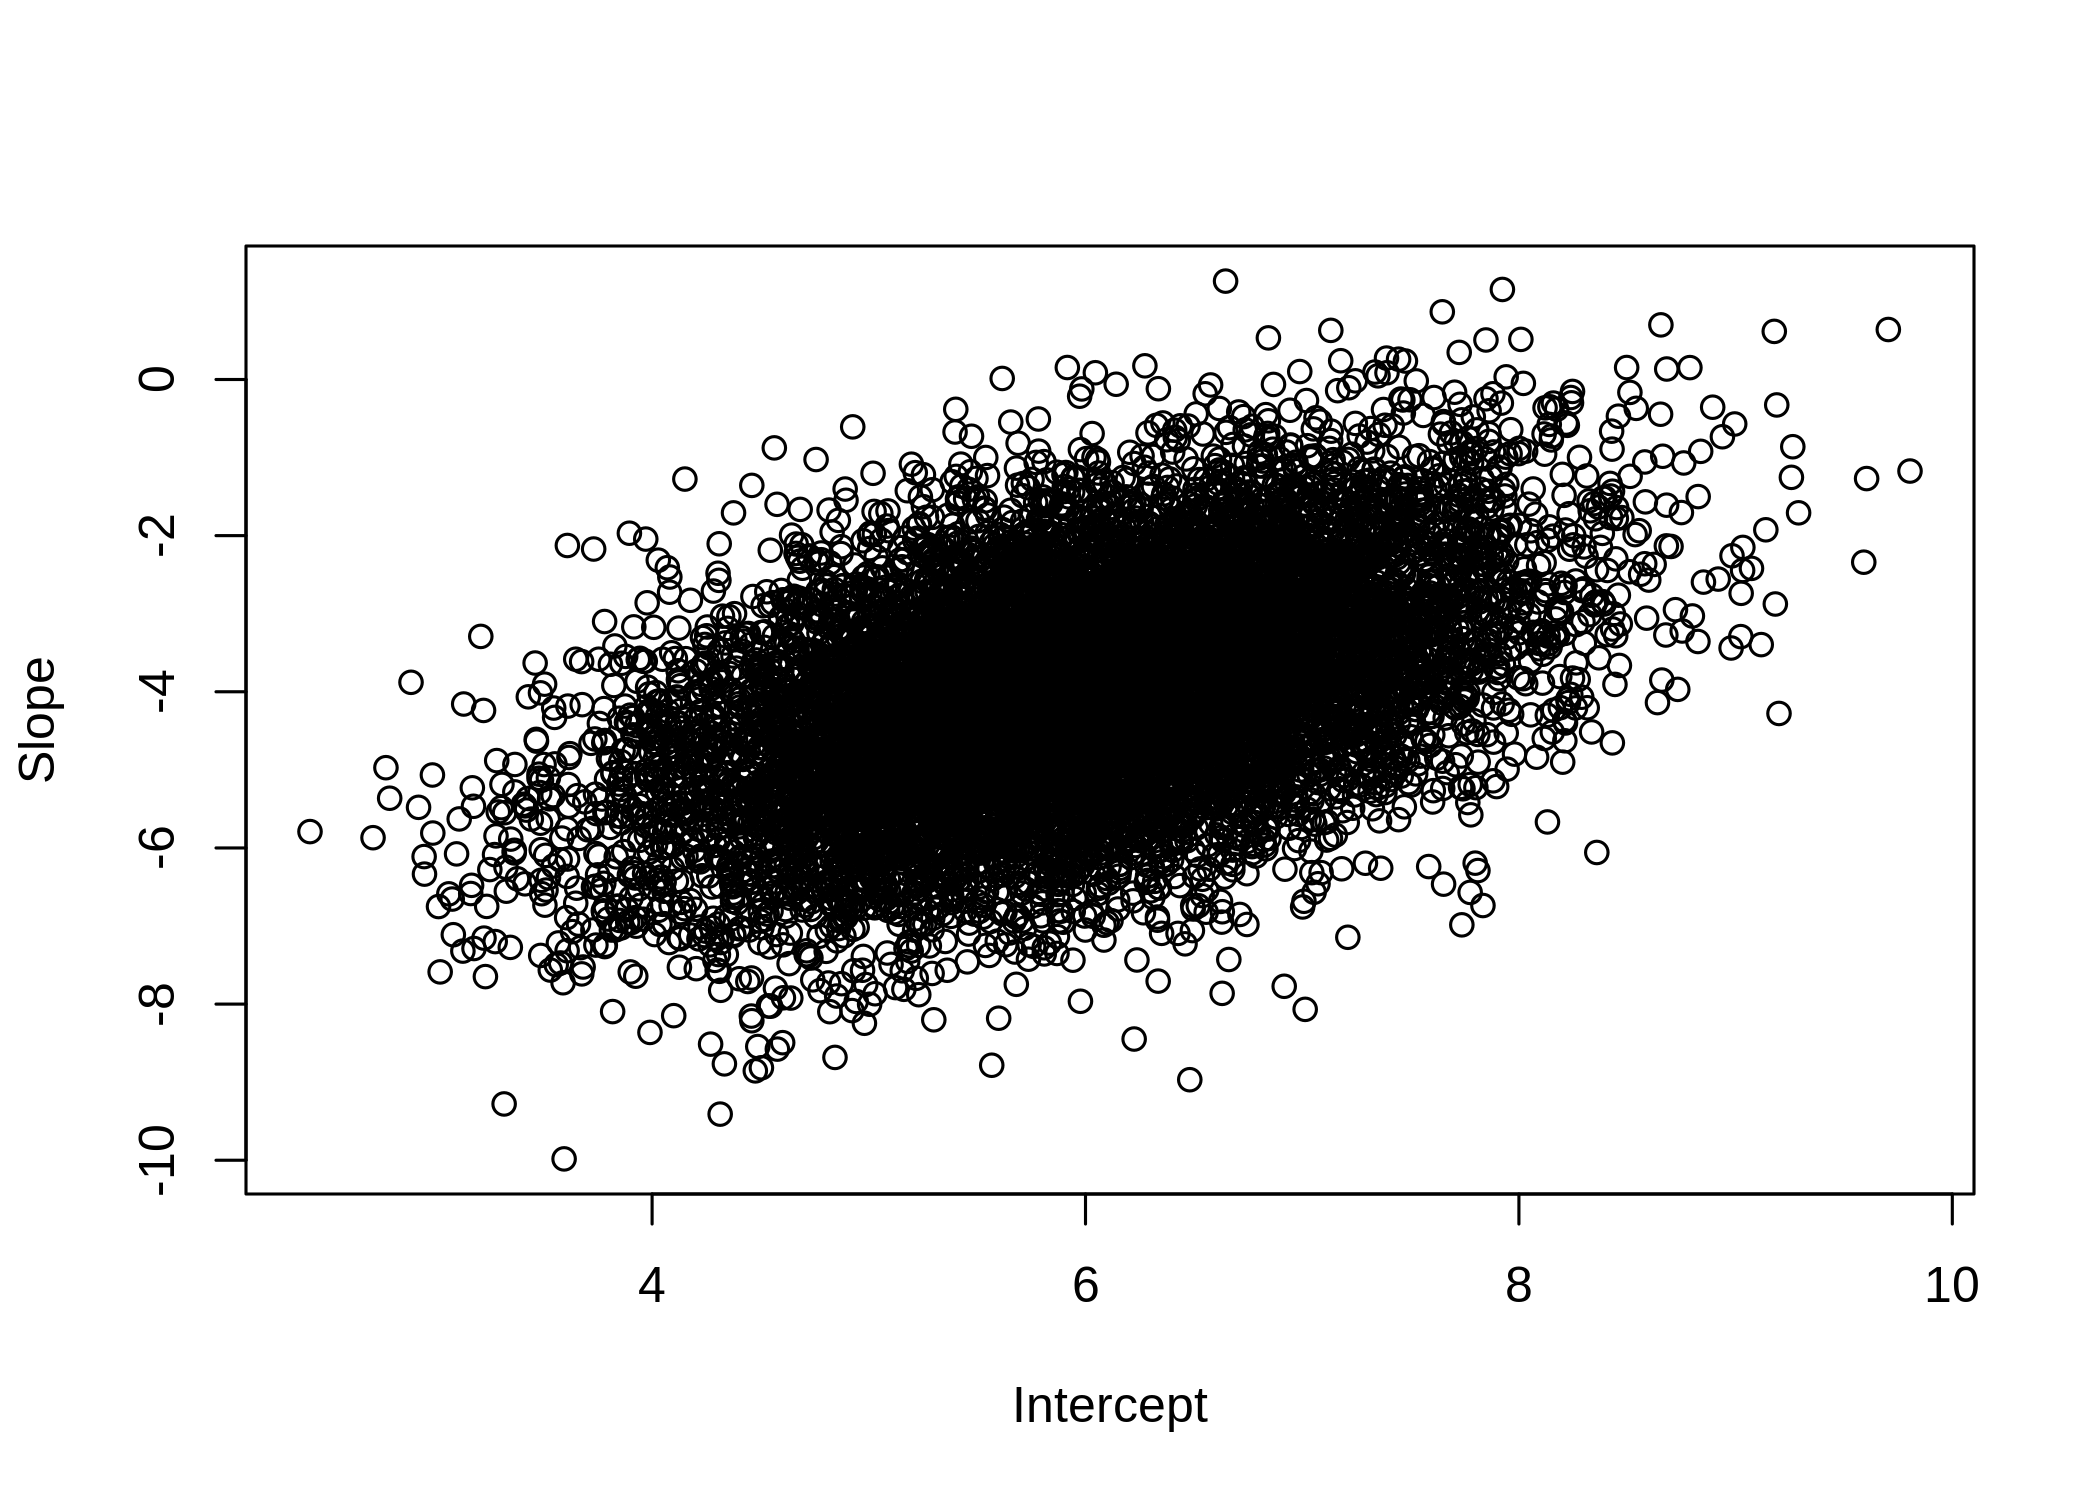

In [38]:
library(MASS)#we will sample from a multivariate normal distribution
varcovmat = matrix(c(1, .66, .66, 2), nrow=2)#here covar = 0.66 = correlation of .33
matrix_mvn = mvrnorm(10000, mu=c(6, -4), Sigma=varcovmat)
plot(matrix_mvn[,1],matrix_mvn[,2], xlab = "Intercept", ylab = "Slope")

In [39]:
data = data.frame()
varcovmat = matrix(c(1, .66, .66, 2), nrow=2)#Same covar matrix
data = data.frame()
for(i in 1:n_participants){
    re = mvrnorm(n=1, mu=c(6, -1), Sigma=varcovmat)#Sampling from the mvn, rescaling according to DV distribution in next lines
    mu_i = re[1]
    b_age = re[2]
    age_tested = runif(runif(1, 5,15), 1, 99)#retesting participant at different random [1,99] ages [5,15] times
    for (age in age_tested){# A for loop in a for loop is especially dirty but more transparent
        age = age/100#We recode age for scale purpose
        ntrials = runif(1, 5, 100)
        subdata = data.frame(trial=1:ntrials)
        mu = mu_i+b_age*age#inducing age diff alpha + beta * IV
        subdata$wm = rnorm(ntrials, mu, sd=sd_wm)
        subdata$participant = as.character(i)
        subdata$age = age #storing age
        data = rbind(data, subdata)
    }
    
}

In [40]:
m3_cov <- lmer(x ~ age + (age|participant), data = means_bysub)#One | only indicates we estimate the covariance between RE

In [41]:
summary(m3_cov)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: x ~ age + (age | participant)
   Data: means_bysub

REML criterion at convergence: 52.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.5775 -0.5253  0.0993  0.5893  1.7260 

Random effects:
 Groups      Name        Variance Std.Dev. Corr
 participant (Intercept) 1.16819  1.0808       
             age         3.42230  1.8499   0.13
 Residual                0.02871  0.1694       
Number of obs: 136, groups:  participant, 15

Fixed effects:
            Estimate Std. Error      df t value Pr(>|t|)    
(Intercept)   5.8338     0.2817 14.1429  20.708 5.59e-12 ***
age          -3.3568     0.4822 13.9188  -6.961 6.85e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
    (Intr)
age 0.110 

In our model the estimation made of the covariance matrix is =
$$\begin{pmatrix} 1.17 & 1.32 \\ 1.32  & 3.42 \end{pmatrix}$$

Note that the random effect variances and covariances are difficult to estimate when we have small sample sizes (as always by the way, e.g. for correlation see [blog post by G. Rousselet](https://garstats.wordpress.com/2018/06/01/smallncorr/))

# Adding another predictor

In [42]:
#First we define our covariance matrix unitless, we later rescale to the values of the DV
varcovmat = matrix(c(1, .33, .33, .33, .33, 1, .33, .33, .33, .33,1,.33, .33, .33, .33,1), nrow=4)#everything is correlated at .33
data = data.frame()
for(i in 1:n_participants){
    re = mvrnorm(n=1, mu=c(0, 0, 0, 0), Sigma=varcovmat)
    mu_i = re[1] * sd_wm + mean_wm #Rescaling so that mean = 6 and sd = 1
    b_age = re[2] *(sd_wm*2) - (sd_wm*4) #b_age_j + rescaling
    b_task = re[3] * sd_wm + -(sd_wm*2)#b_task_j + rescaling
    b_age_task = re[4] * (sd_wm/2) - (sd_wm*2)#b_agetask_j + rescaling
    age_tested = runif(runif(1, 5,15), 1, 99)
    for (age in age_tested){# for loop in for loops is especially dirty but more transparent
        age = age/100#We recode age for scale purpose
        for (task in c(0,1)){
            ntrials = runif(1, 50, 150)
            subdata = data.frame(trial=1:ntrials)
            mu = mu_i+b_age*age+b_task*task+b_age_task*age*task
            subdata$wm = rnorm(ntrials, mu, sd=sd_wm)
            subdata$participant = as.character(i)
            subdata$age = age 
            subdata$task = task
            data = rbind(data, subdata)
        }
    }
}
means_ = aggregate(data$wm, FUN=mean, 
          by=list(age=data$age, task=data$task, participant = data$participant))#pre-averaging at first

In [43]:
m4 <- lmer(x ~ age * task + (1+age*task|participant), data = means_)

Warning message in checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv, :
“Model failed to converge with max|grad| = 0.0028704 (tol = 0.002, component 1)”


We have a convergence error, max likelihood optimizer is having some trouble converging (when you get convergence problems, see this [page](https://rstudio-pubs-static.s3.amazonaws.com/33653_57fc7b8e5d484c909b615d8633c01d51.html)). 

In our case we can simply change the optimization criterion


In [44]:
library(optimx)
m4 <- lmer(x ~ age * task + (1+age*task|participant), data = means_, 
           control = lmerControl(optimizer = "optimx", calc.derivs = FALSE,
           optCtrl = list(method = "nlminb", starttests = FALSE, kkt = FALSE)))

But warnings can be informative about the structure of the LMM we are trying to fit, e.g. we could have more parameters than observations

In [45]:
#m4_wrong <- lmer(x ~ age * task + (1+age*task|participant), data = means_[means_$age < .1,])

Problem is also the number of units in your random effects. The higher the number the better will be the estimation of variance (and co-variance !) of random effects

In [46]:
summary(m4)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: x ~ age * task + (1 + age * task | participant)
   Data: means_
Control: 
lmerControl(optimizer = "optimx", calc.derivs = FALSE, optCtrl = list(method = "nlminb",  
    starttests = FALSE, kkt = FALSE))

REML criterion at convergence: -83.7

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.62389 -0.58975 -0.00013  0.56033  3.01961 

Random effects:
 Groups      Name        Variance Std.Dev. Corr          
 participant (Intercept) 1.147251 1.07110                
             age         3.118870 1.76603  0.48          
             task        0.752606 0.86753  0.50 0.44     
             age:task    0.261845 0.51171  0.56 0.23 0.27
 Residual                0.009878 0.09939                
Number of obs: 216, groups:  participant, 15

Fixed effects:
            Estimate Std. Error      df t value Pr(>|t|)    
(Intercept)   6.0378     0.2774 14.0103  21.768 3.35e-12 ***
age 

## Plotting the multiple predictor model

In [47]:
#install.packages("sjPlot")
library("sjPlot")
library(sjlabelled)
library(sjmisc)
library(ggplot2)


Attaching package: ‘sjlabelled’


The following object is masked from ‘package:forcats’:

    as_factor


The following object is masked from ‘package:dplyr’:

    as_label



Attaching package: ‘sjmisc’


The following object is masked from ‘package:purrr’:

    is_empty


The following object is masked from ‘package:tidyr’:

    replace_na


The following object is masked from ‘package:tibble’:

    add_case




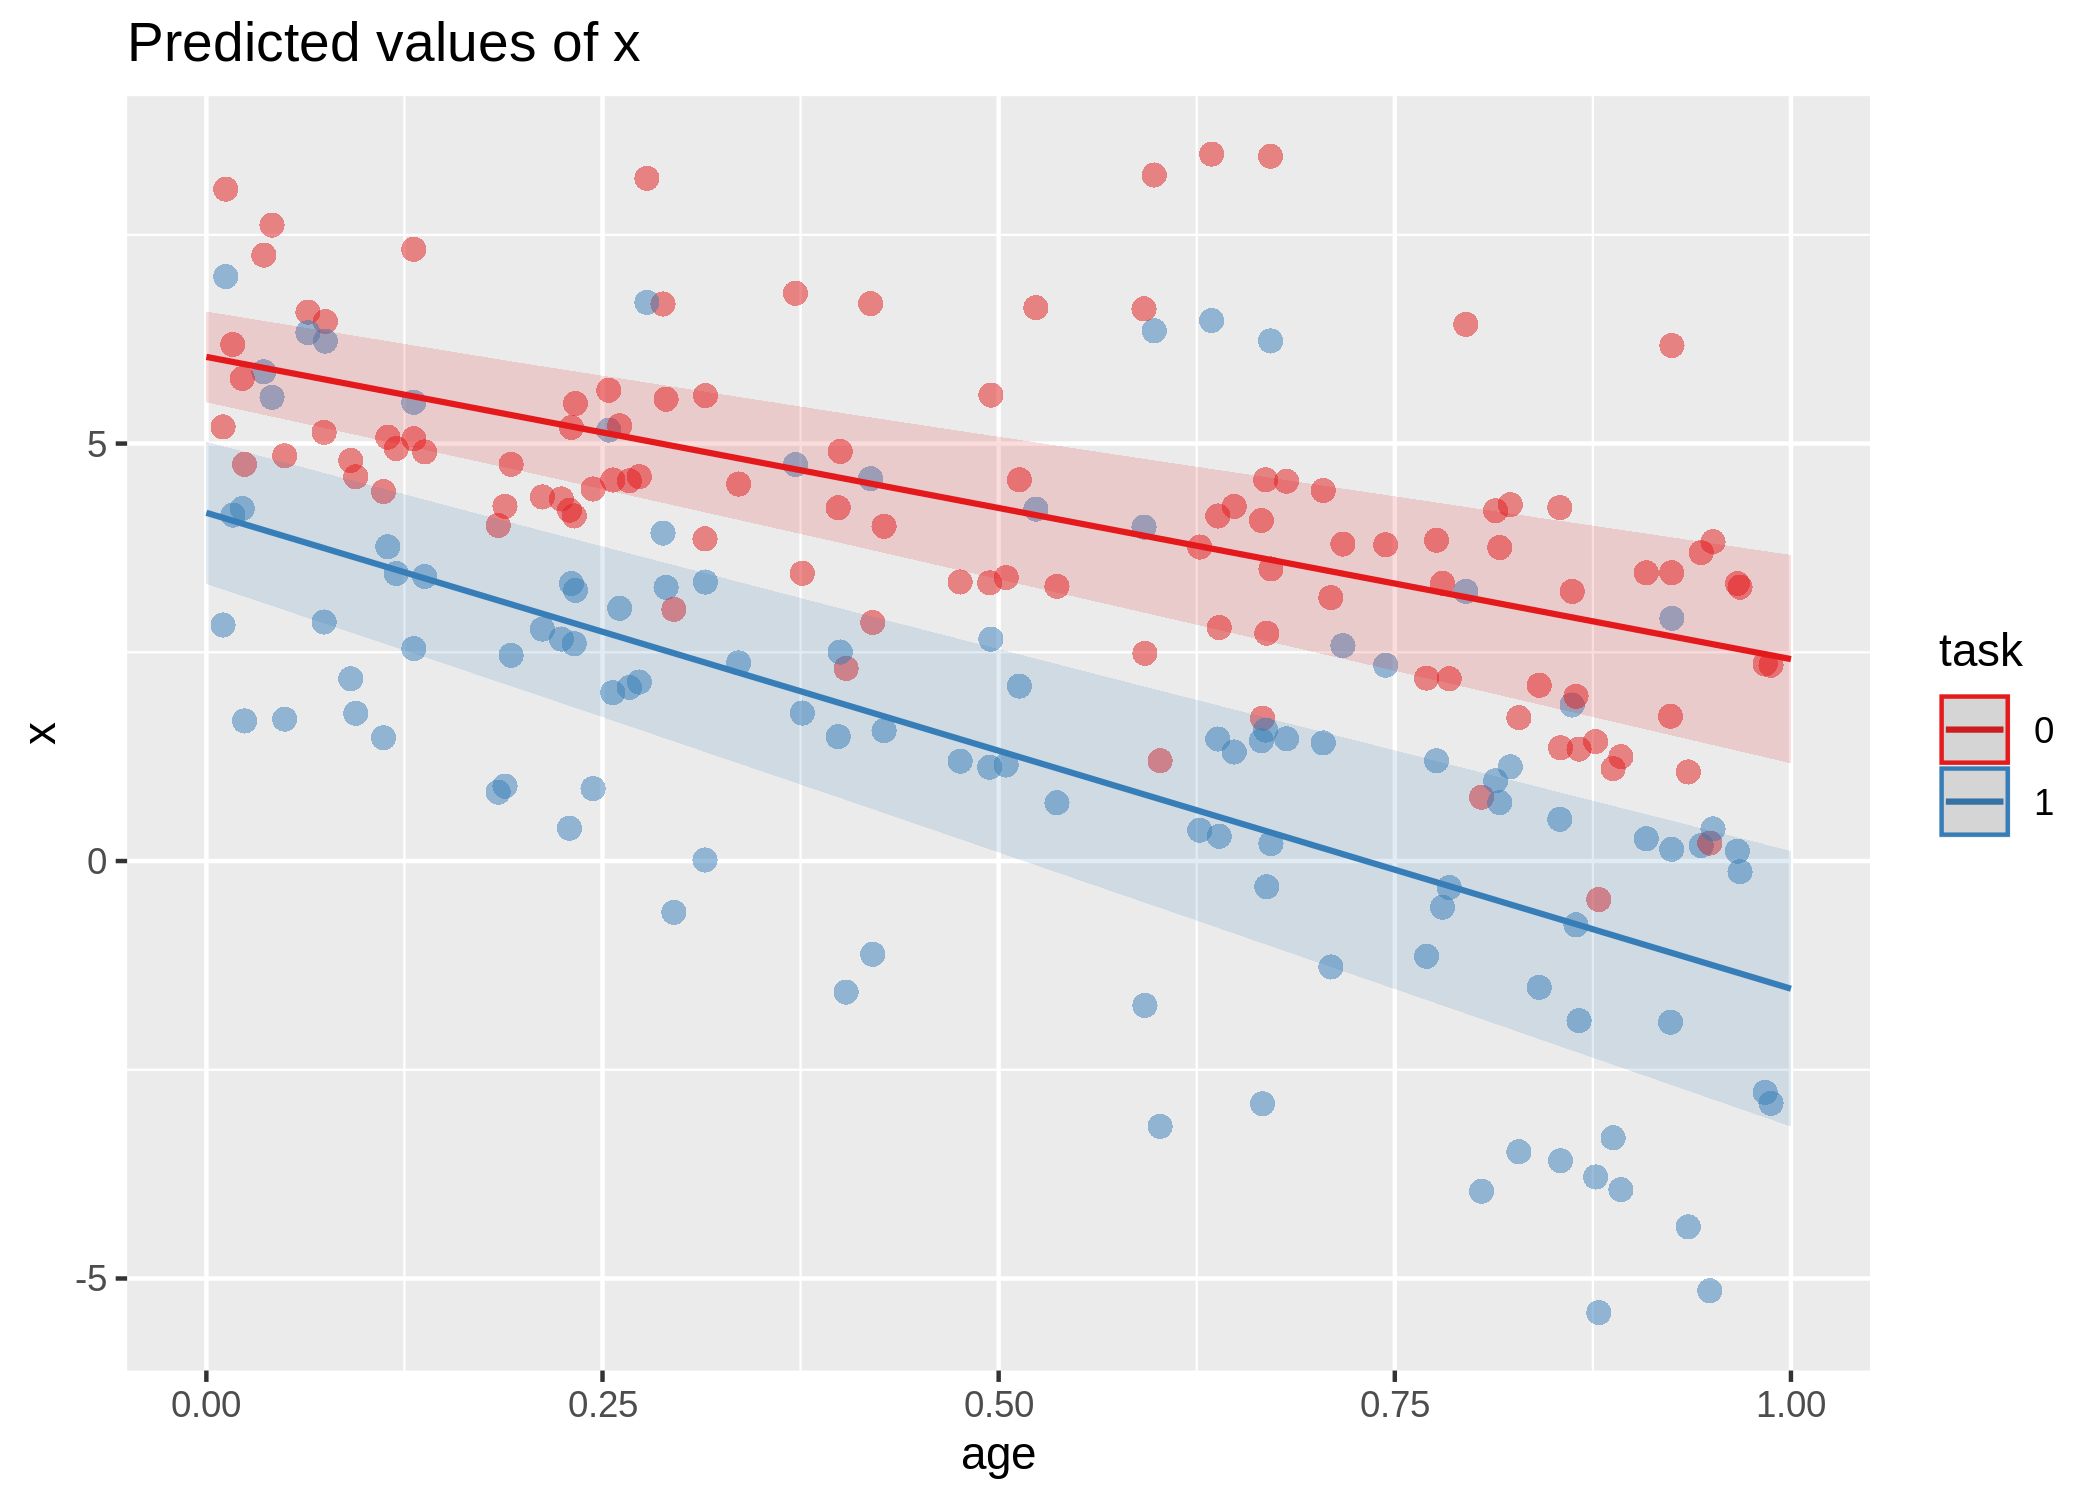

In [48]:
plot_model(m4, type = "pred", terms = c("age", "task"), show.data = TRUE)

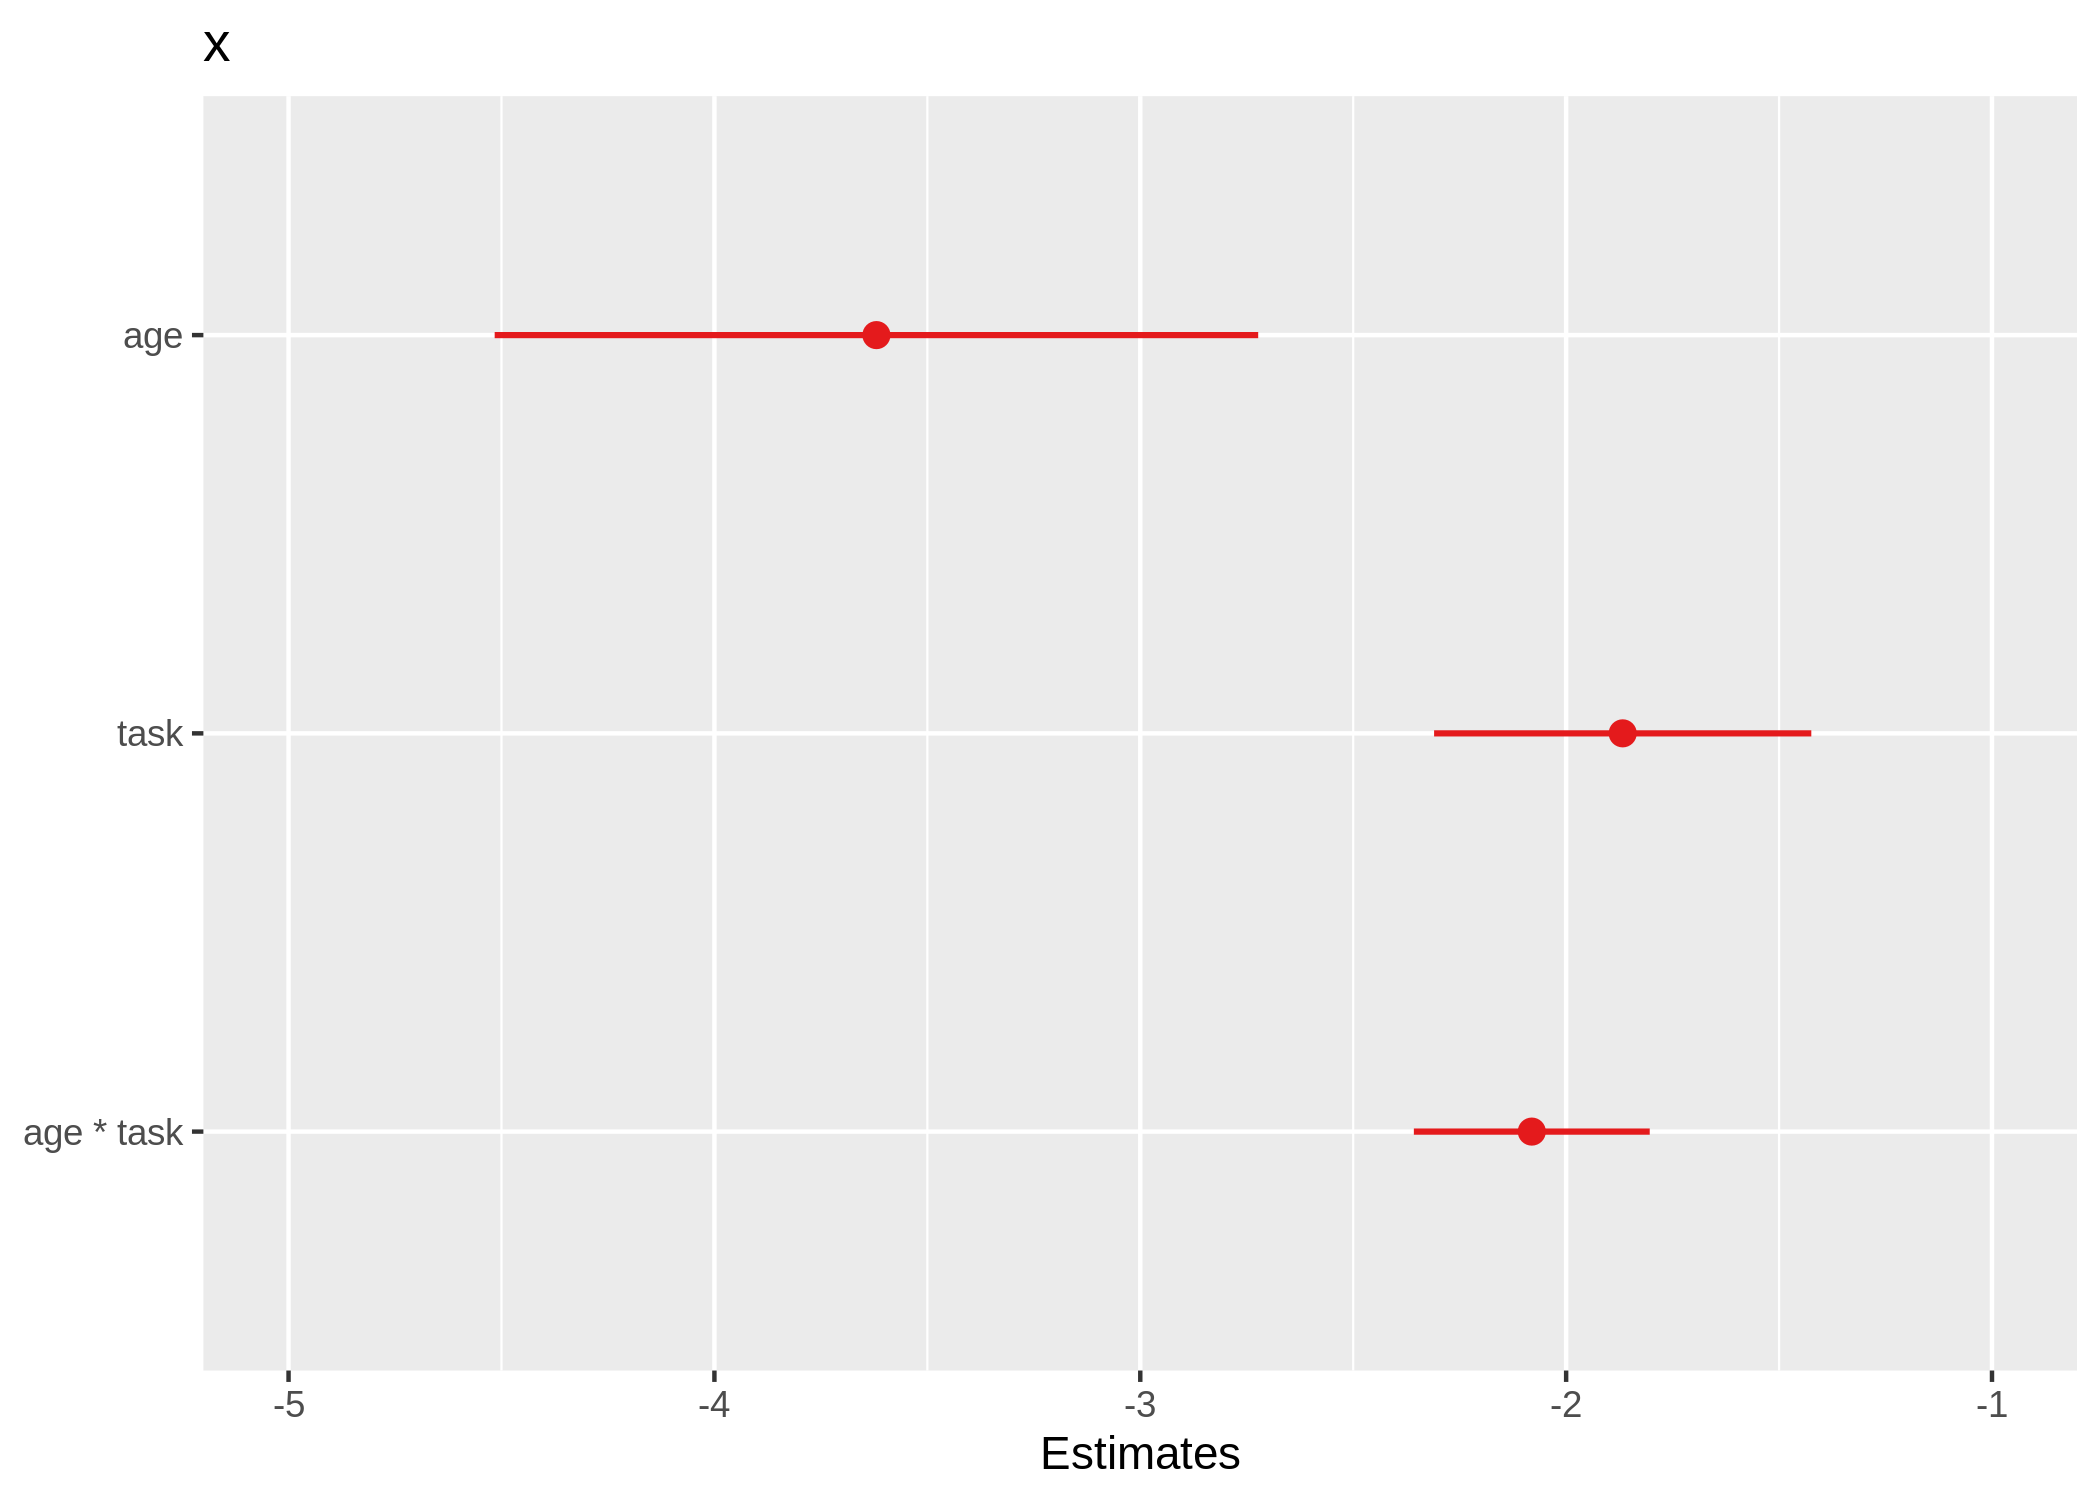

In [49]:
#install.packages('glmmTMB')
plot_model(m4, type = "est")

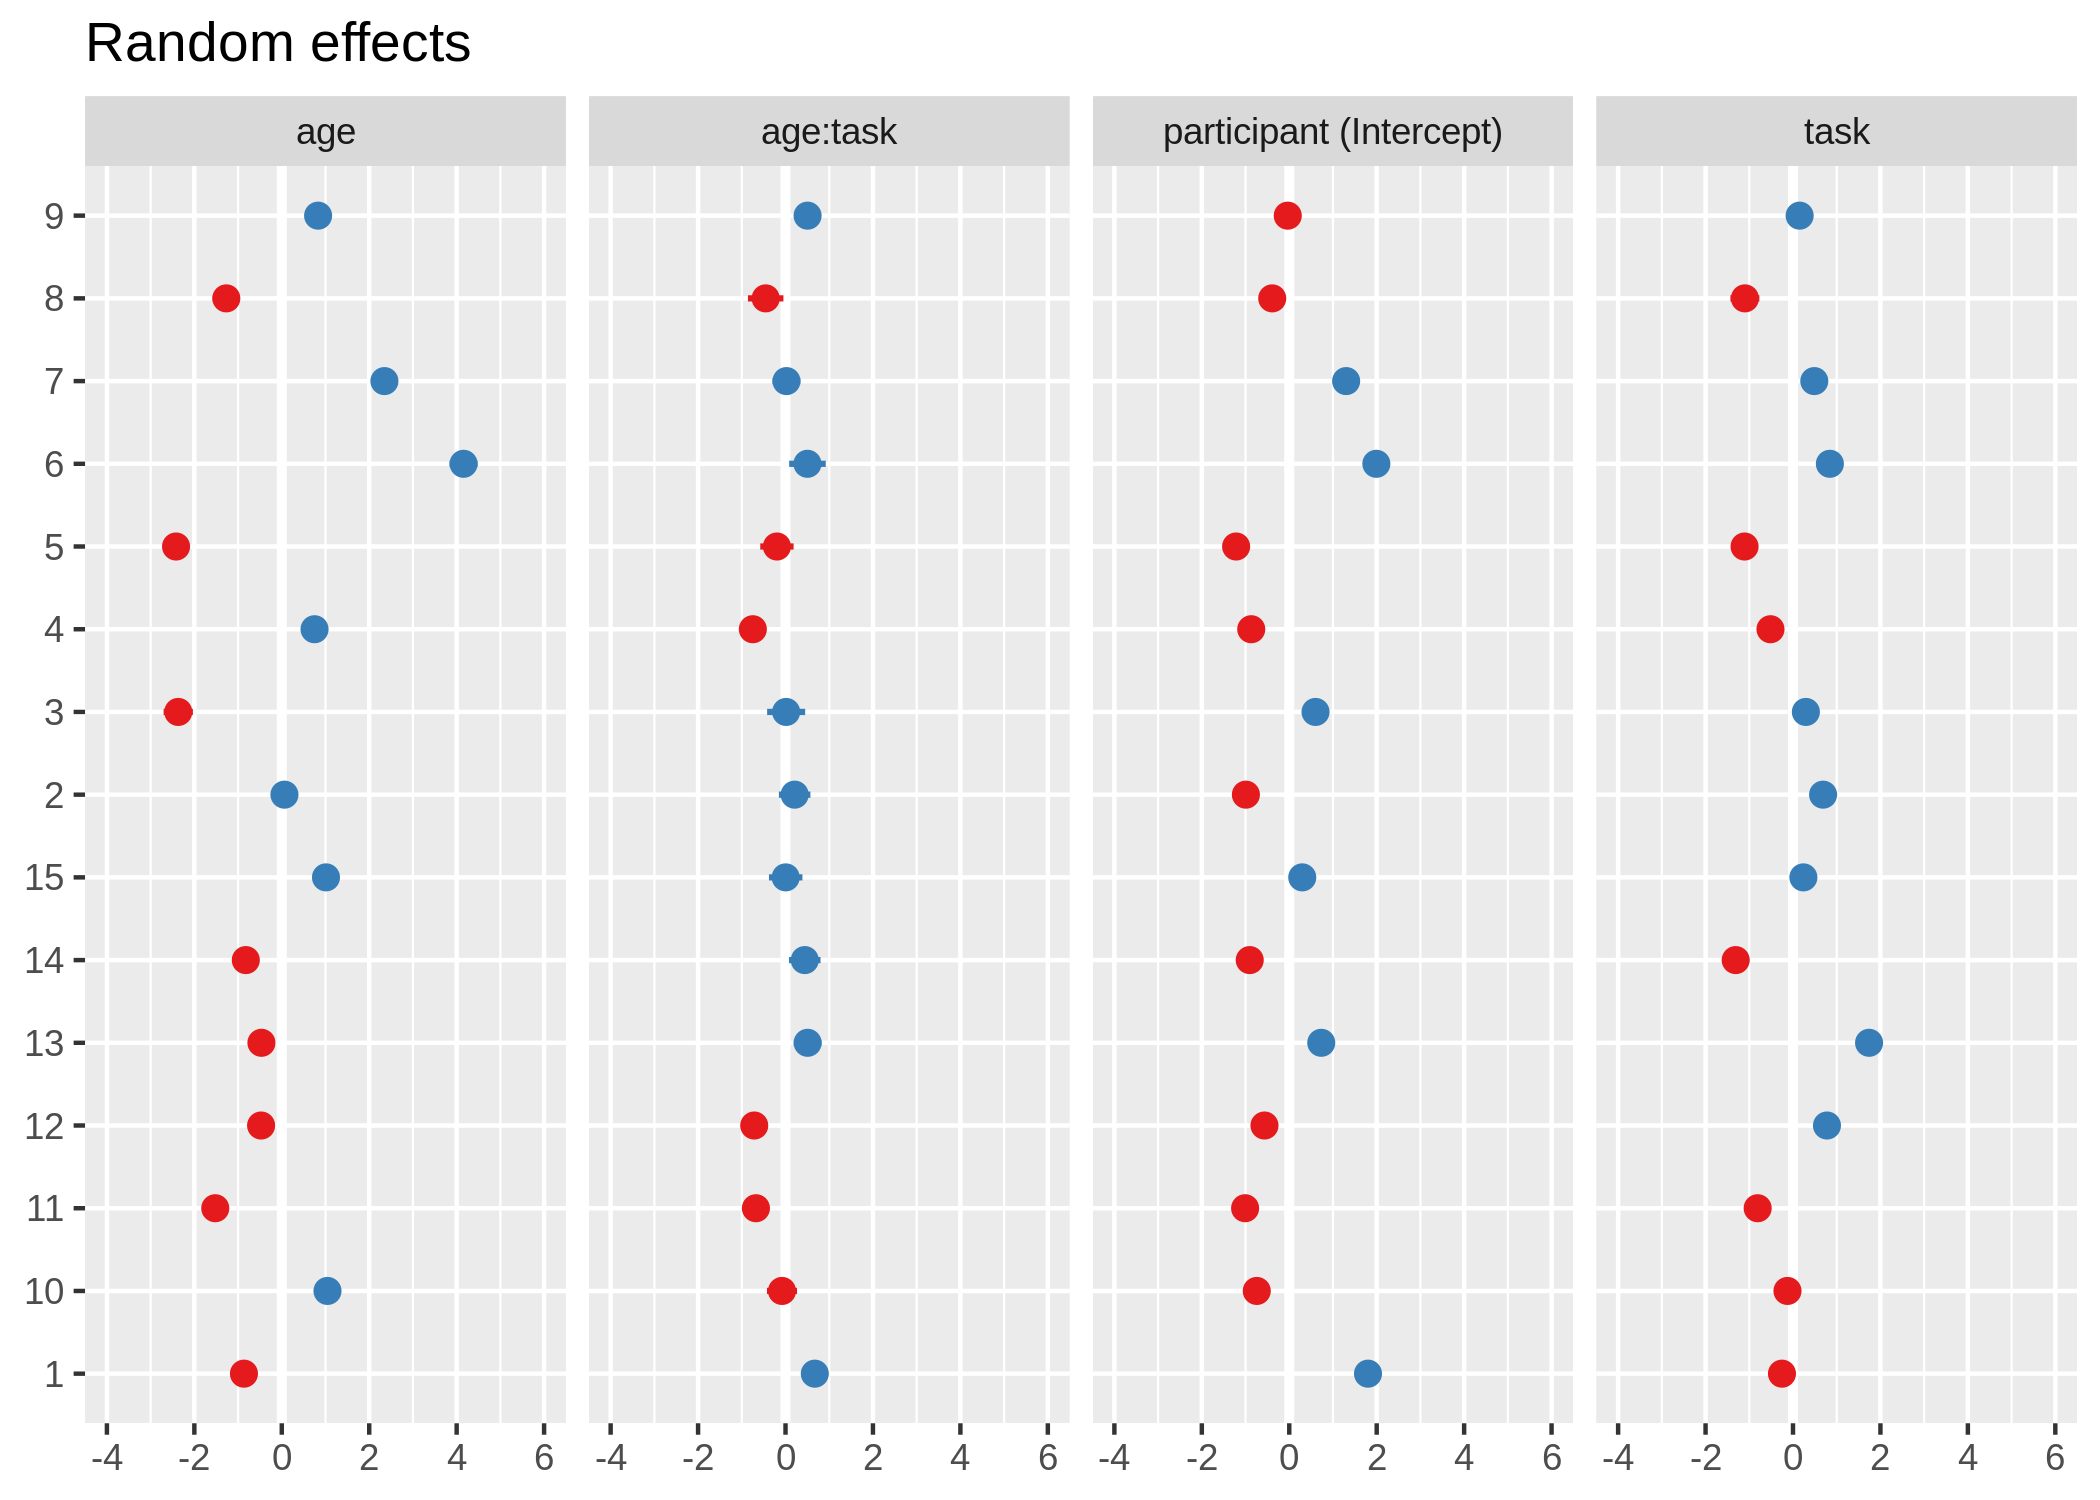

In [50]:
#install.packages('glmmTMB')
plot_model(m4, type = "re")

### Now checking models assumption

In [51]:
library(performance)

Loading required namespace: qqplotr

For confidence bands, please install `qqplotr`.



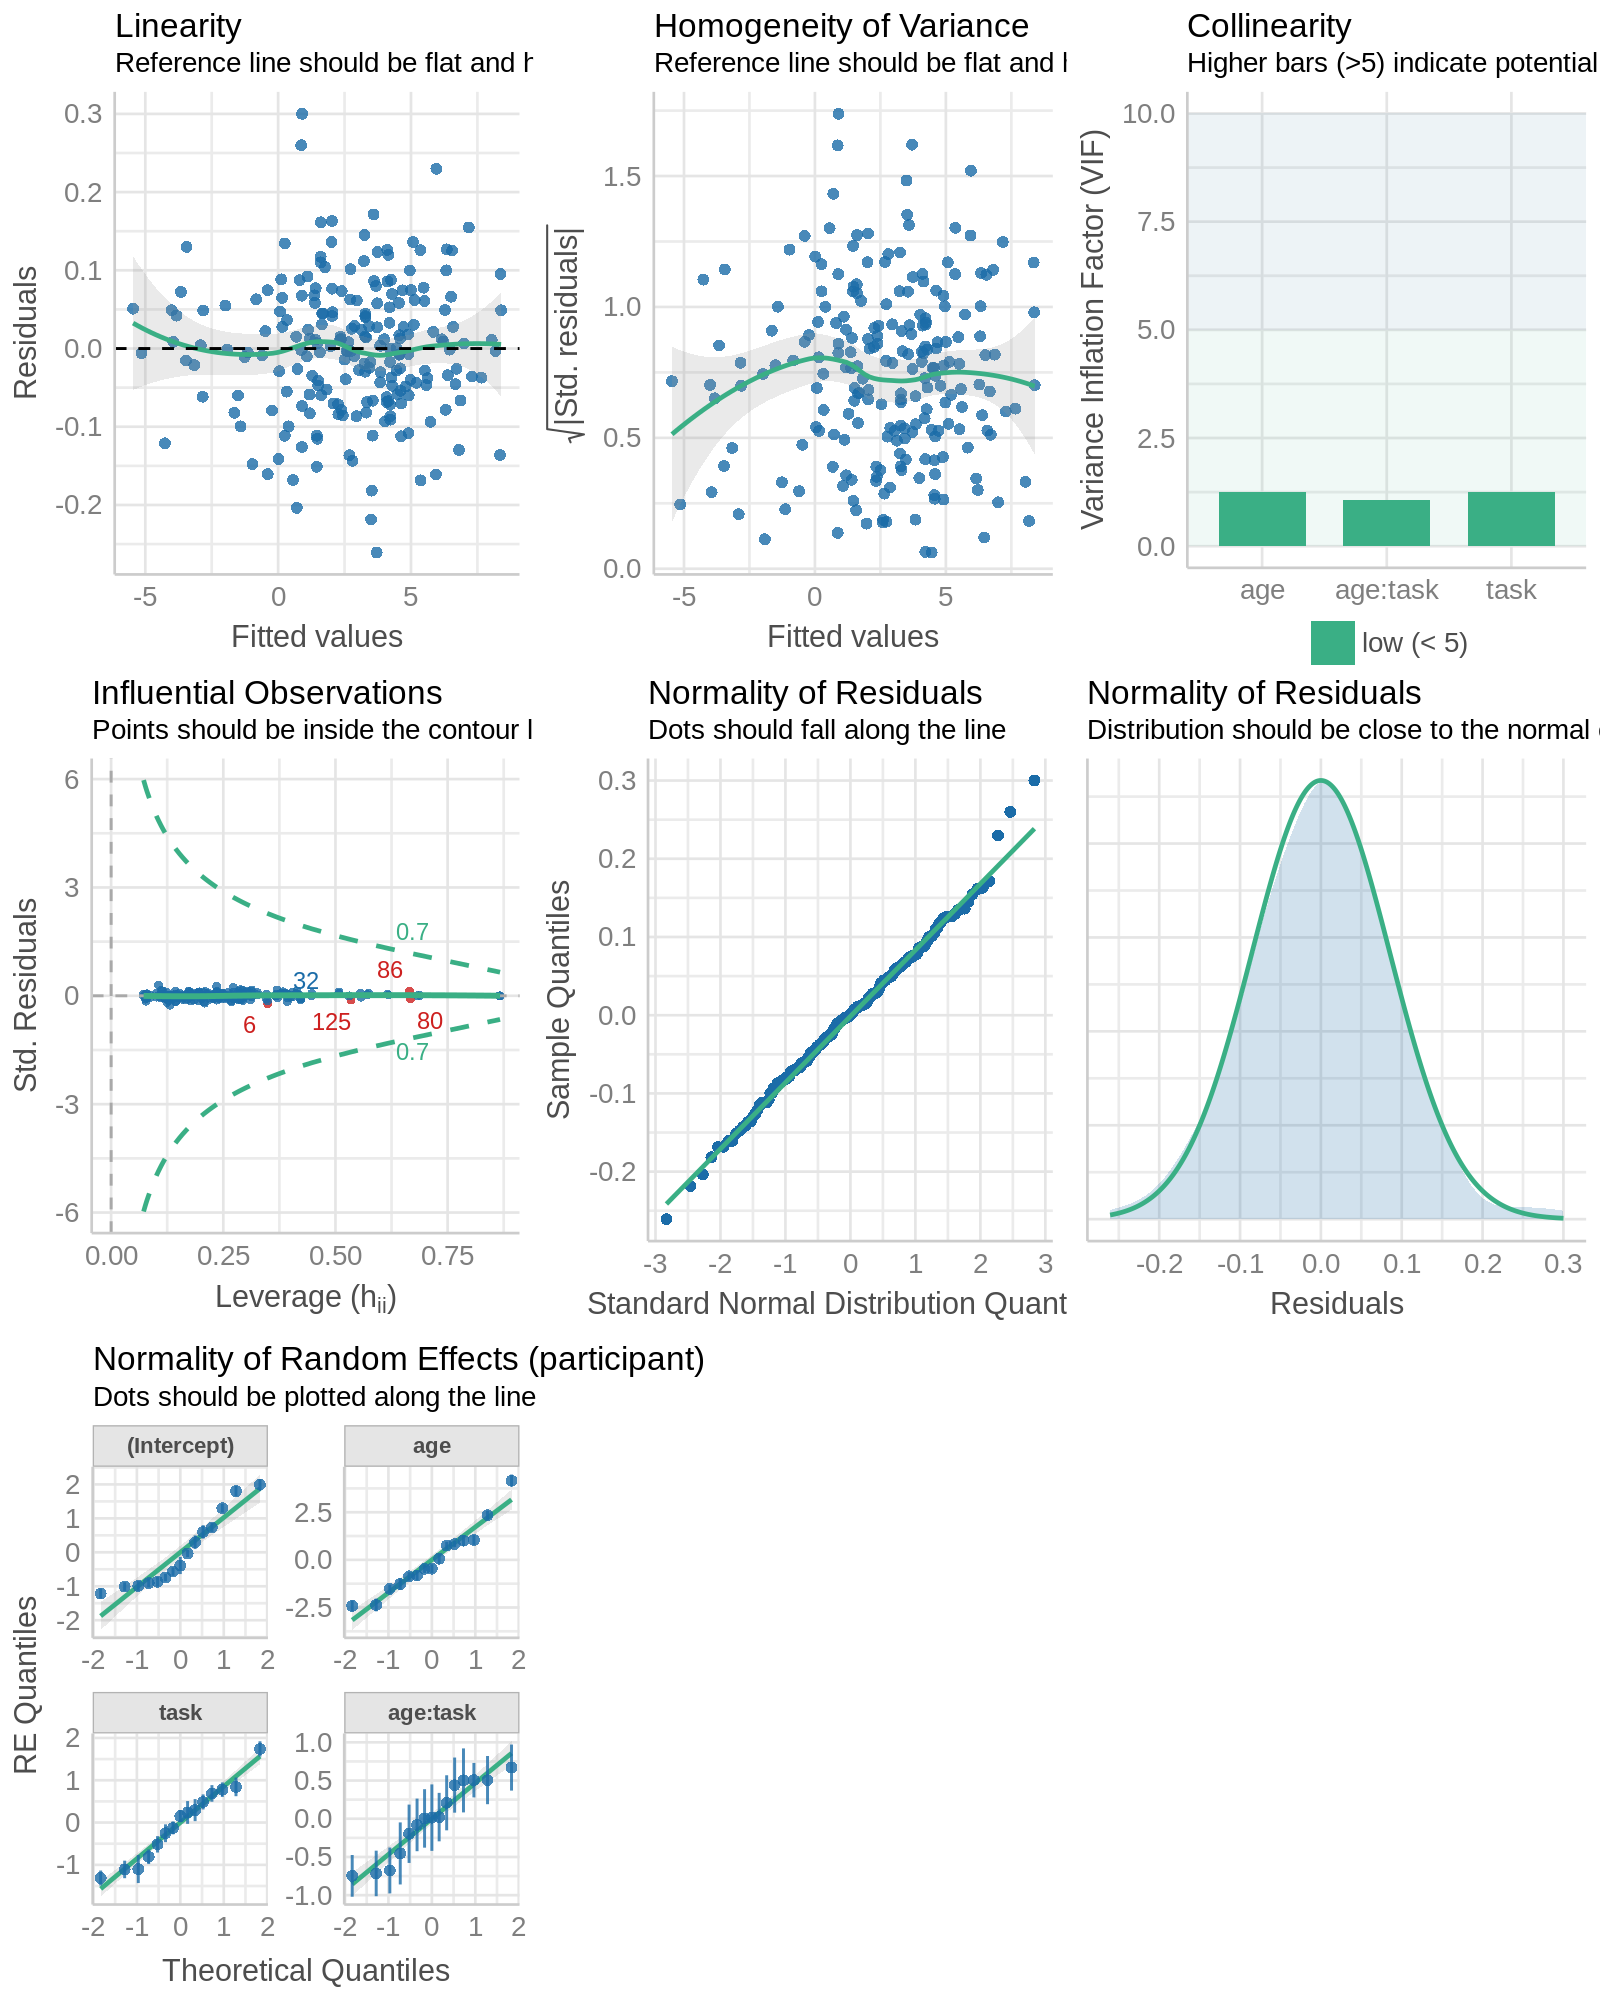

In [52]:
options(repr.plot.width=8, repr.plot.height=10, repr.plot.res = 100)#hidden code for display size
check_model(m4)
options(repr.plot.width=8, repr.plot.height=5, repr.plot.res = 200)#hidden code for display size

# Fitting a LMM at the trial level

Here we build a linear mixed model with all fixed effects (simple and interaction) and all random effects (intercept and all effects) at the trial level (without pre-averaging) 

-> We use the model with the maximum of information where averaging is part of the model

In [53]:
full_trial_fullFE <- lmer(wm ~ age * task + (age*task|participant), data = data, 
           control = lmerControl(optimizer = "optimx", calc.derivs = FALSE,
           optCtrl = list(method = "nlminb", starttests = FALSE, kkt = FALSE)))

In [54]:
summary(full_trial_fullFE)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: wm ~ age * task + (age * task | participant)
   Data: data
Control: 
lmerControl(optimizer = "optimx", calc.derivs = FALSE, optCtrl = list(method = "nlminb",  
    starttests = FALSE, kkt = FALSE))

REML criterion at convergence: 60887.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.6648 -0.6854  0.0110  0.6718  3.5132 

Random effects:
 Groups      Name        Variance Std.Dev. Corr          
 participant (Intercept) 1.1317   1.0638                 
             age         3.0951   1.7593   0.48          
             task        0.7551   0.8690   0.51 0.44     
             age:task    0.2507   0.5007   0.58 0.24 0.30
 Residual                1.0123   1.0061                 
Number of obs: 21260, groups:  participant, 15

Fixed effects:
            Estimate Std. Error      df t value Pr(>|t|)    
(Intercept)   6.0423     0.2756 14.0087  21.923 3.05e-12 ***
age          -3

In [55]:
summary(m4)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: x ~ age * task + (1 + age * task | participant)
   Data: means_
Control: 
lmerControl(optimizer = "optimx", calc.derivs = FALSE, optCtrl = list(method = "nlminb",  
    starttests = FALSE, kkt = FALSE))

REML criterion at convergence: -83.7

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.62389 -0.58975 -0.00013  0.56033  3.01961 

Random effects:
 Groups      Name        Variance Std.Dev. Corr          
 participant (Intercept) 1.147251 1.07110                
             age         3.118870 1.76603  0.48          
             task        0.752606 0.86753  0.50 0.44     
             age:task    0.261845 0.51171  0.56 0.23 0.27
 Residual                0.009878 0.09939                
Number of obs: 216, groups:  participant, 15

Fixed effects:
            Estimate Std. Error      df t value Pr(>|t|)    
(Intercept)   6.0378     0.2774 14.0103  21.768 3.35e-12 ***
age 

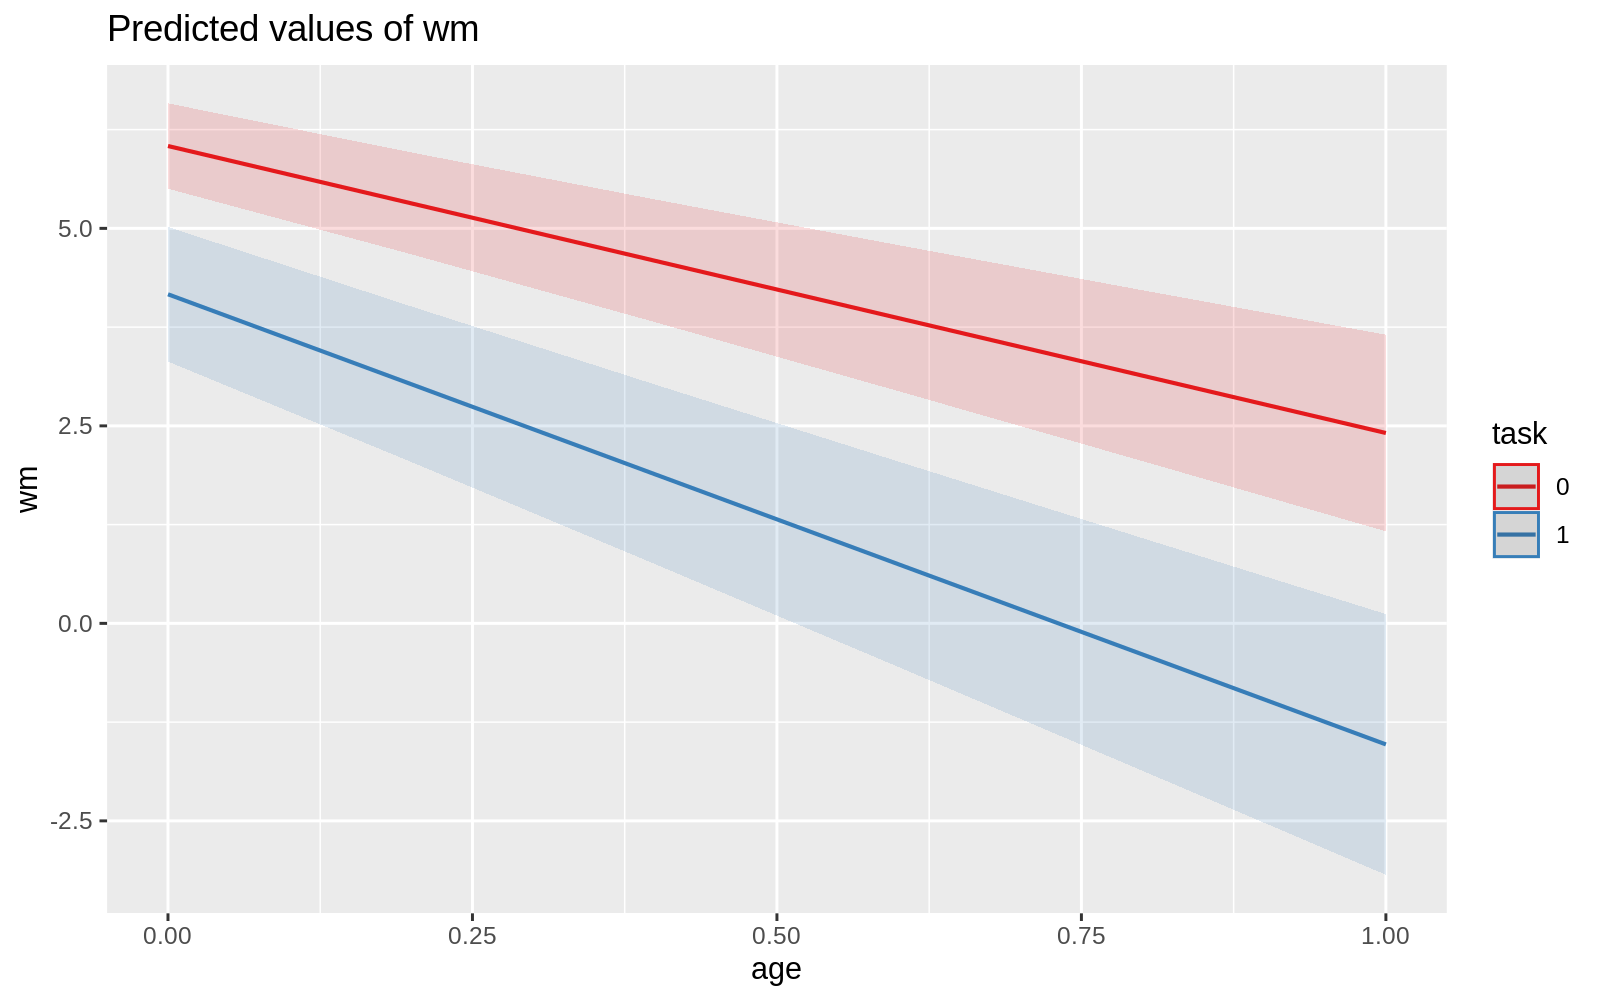

In [56]:
plot_model(full_trial_fullFE, type = "pred", terms = c("age", "task"), show.data = FALSE)

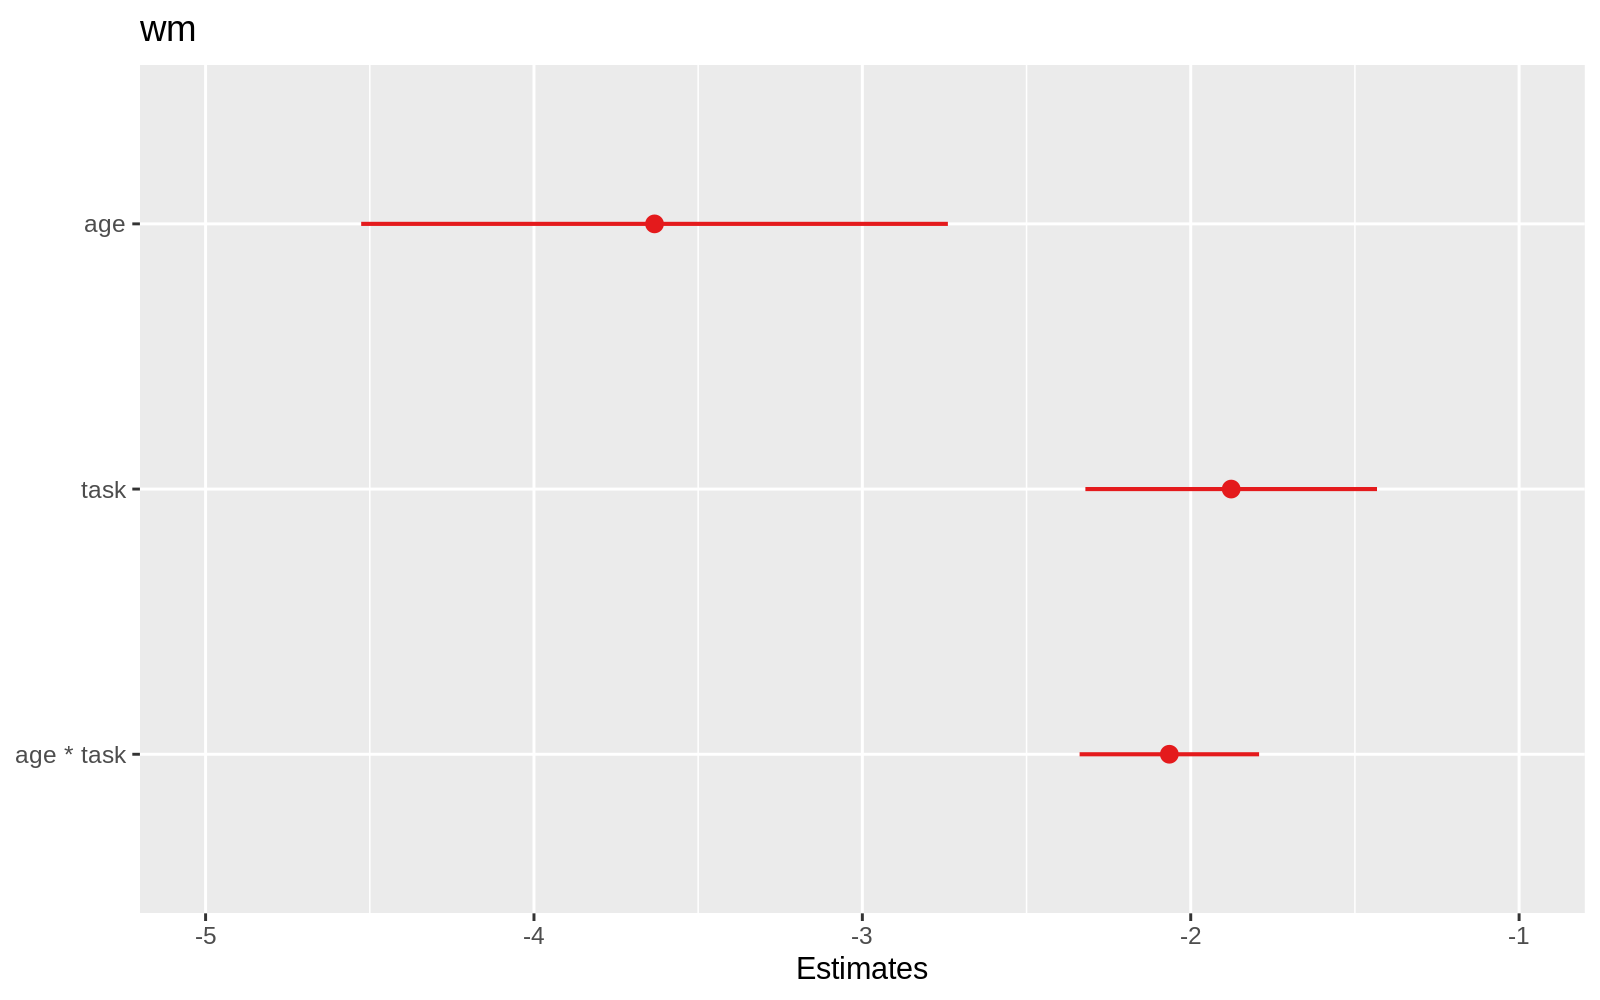

In [57]:
plot_model(full_trial_fullFE)

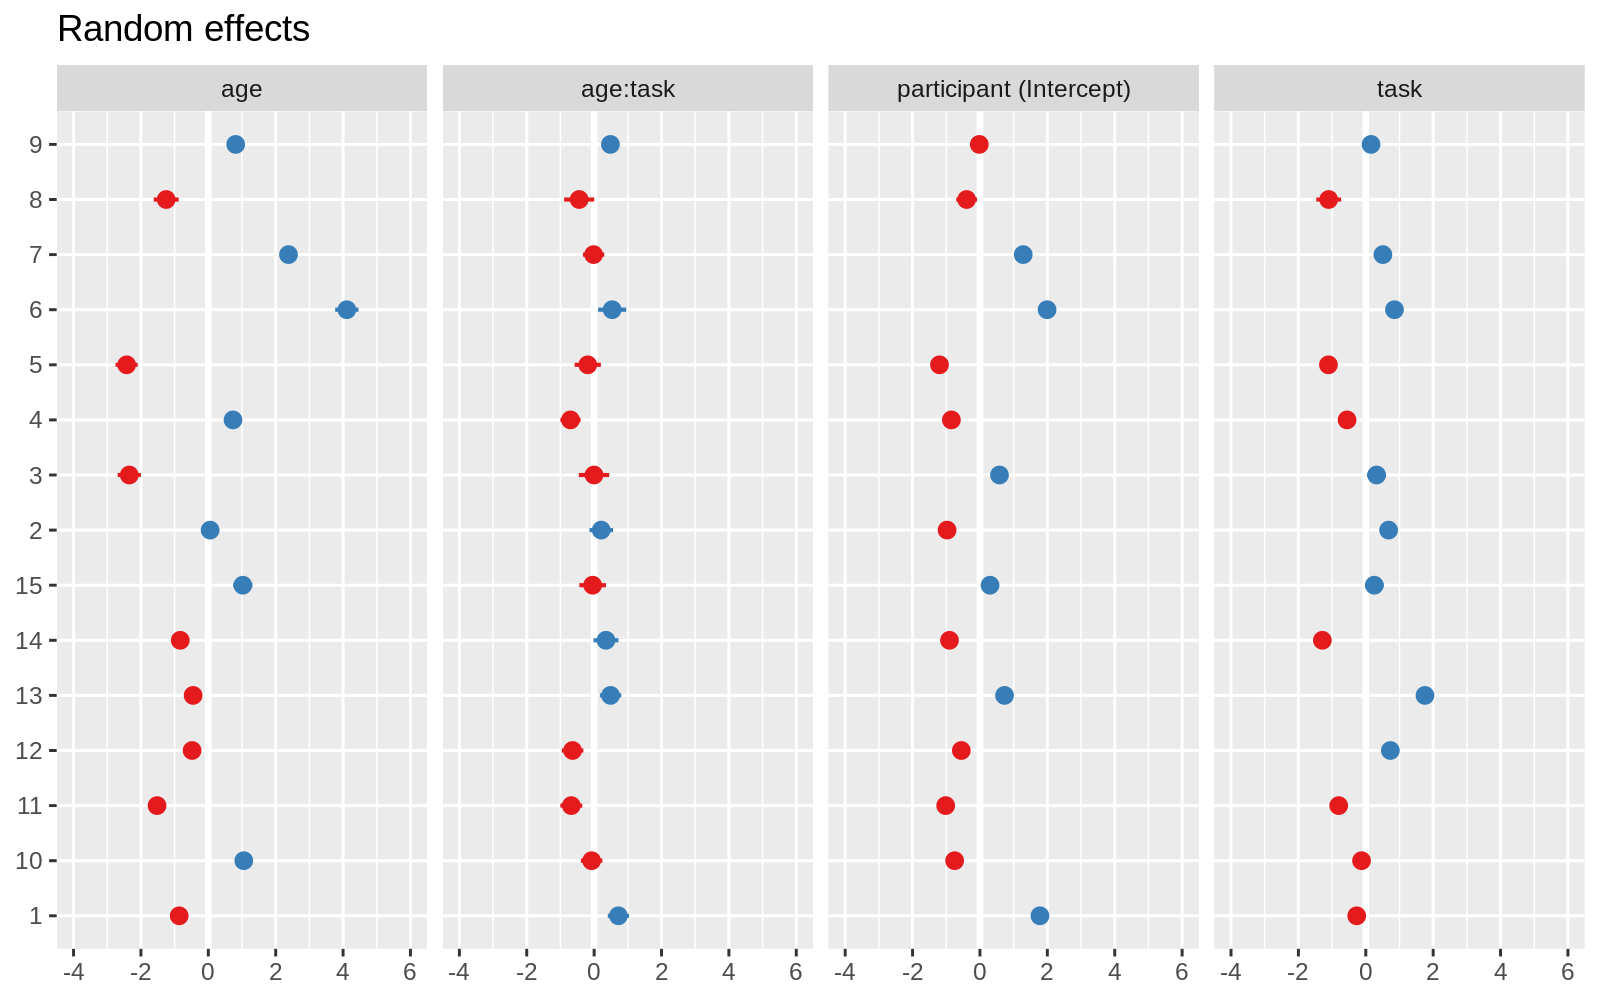

In [58]:
plot_model(full_trial_fullFE, type="re")

## And the assumption of our model ??

In [59]:
#check_model(full_trial_fullFE)# eats too much RAM and therefore too slow so I saved it in advance

<img src="https://raw.githubusercontent.com/GWeindel/lecture_mixed_models_AMU_2021/main/plots/model_check.png">

# Other sources of randomness

A cross random factor mixed model _E.g._ if each trial had a different wm test/stimuli

In [60]:
random_mu_trial = rnorm(50, 0, 1)#A simple random effect where each trial has its own mean

In [61]:
varcovmat = matrix(c(1, .33, .33, .33, .33, 1, .33, .33, .33, .33,1,.33, .33, .33, .33,1), nrow=4)
data = data.frame()
for(i in 1:n_participants){
    re = mvrnorm(n=1, mu=c(0, 0, 0, 0), Sigma=varcovmat)
    mu_i = re[1] * sd_wm + mean_wm
    b_age = re[2] *(sd_wm*2) - (sd_wm*4) #b_age_j
    b_task = re[3] * sd_wm + -(sd_wm*2)#b_task_j
    b_age_task = re[4] * (sd_wm/2) - (sd_wm*2)#b_agetask_j
    age_tested = runif(runif(1, 5,15), 1, 99)
    for (age in age_tested){
        age = age/100
        for (task in c(0,1)){
            ntrials = 50
            subdata = data.frame(trial=1:ntrials)
            mu = mu_i+b_age*age+b_task*task+b_age_task*age*task
            subdata$wm = rnorm(50, mu, sd=sd_wm)
            subdata$wm = subdata$wm + rnorm(50, random_mu_trial, 1)#drawing 1 samples for the 50 trials with the 50 mu
            subdata$participant = as.character(i)
            subdata$age = age 
            subdata$task = task
            subdata$trial = 1:50#trial n
            data = rbind(data, subdata)
        }
    }
}

In [62]:
full_trial_fullFERE <- lmer(wm ~ task * age + (task * age|participant) + (1|trial), data = data, 
           control = lmerControl(optimizer = "optimx", calc.derivs = FALSE,
           optCtrl = list(method = "nlminb", starttests = FALSE, kkt = FALSE)))

In [63]:
summary(full_trial_fullFERE)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: wm ~ task * age + (task * age | participant) + (1 | trial)
   Data: data
Control: 
lmerControl(optimizer = "optimx", calc.derivs = FALSE, optCtrl = list(method = "nlminb",  
    starttests = FALSE, kkt = FALSE))

REML criterion at convergence: 52240.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.6949 -0.6614  0.0035  0.6593  3.9869 

Random effects:
 Groups      Name        Variance Std.Dev. Corr          
 trial       (Intercept) 0.6099   0.7809                 
 participant (Intercept) 1.0478   1.0236                 
             task        1.0811   1.0397   0.37          
             age         5.0708   2.2518   0.62 0.55     
             task:age    0.2799   0.5290   0.13 0.24 0.52
 Residual                1.9822   1.4079                 
Number of obs: 14700, groups:  trial, 50; participant, 15

Fixed effects:
            Estimate Std. Error      df t value Pr(>|t

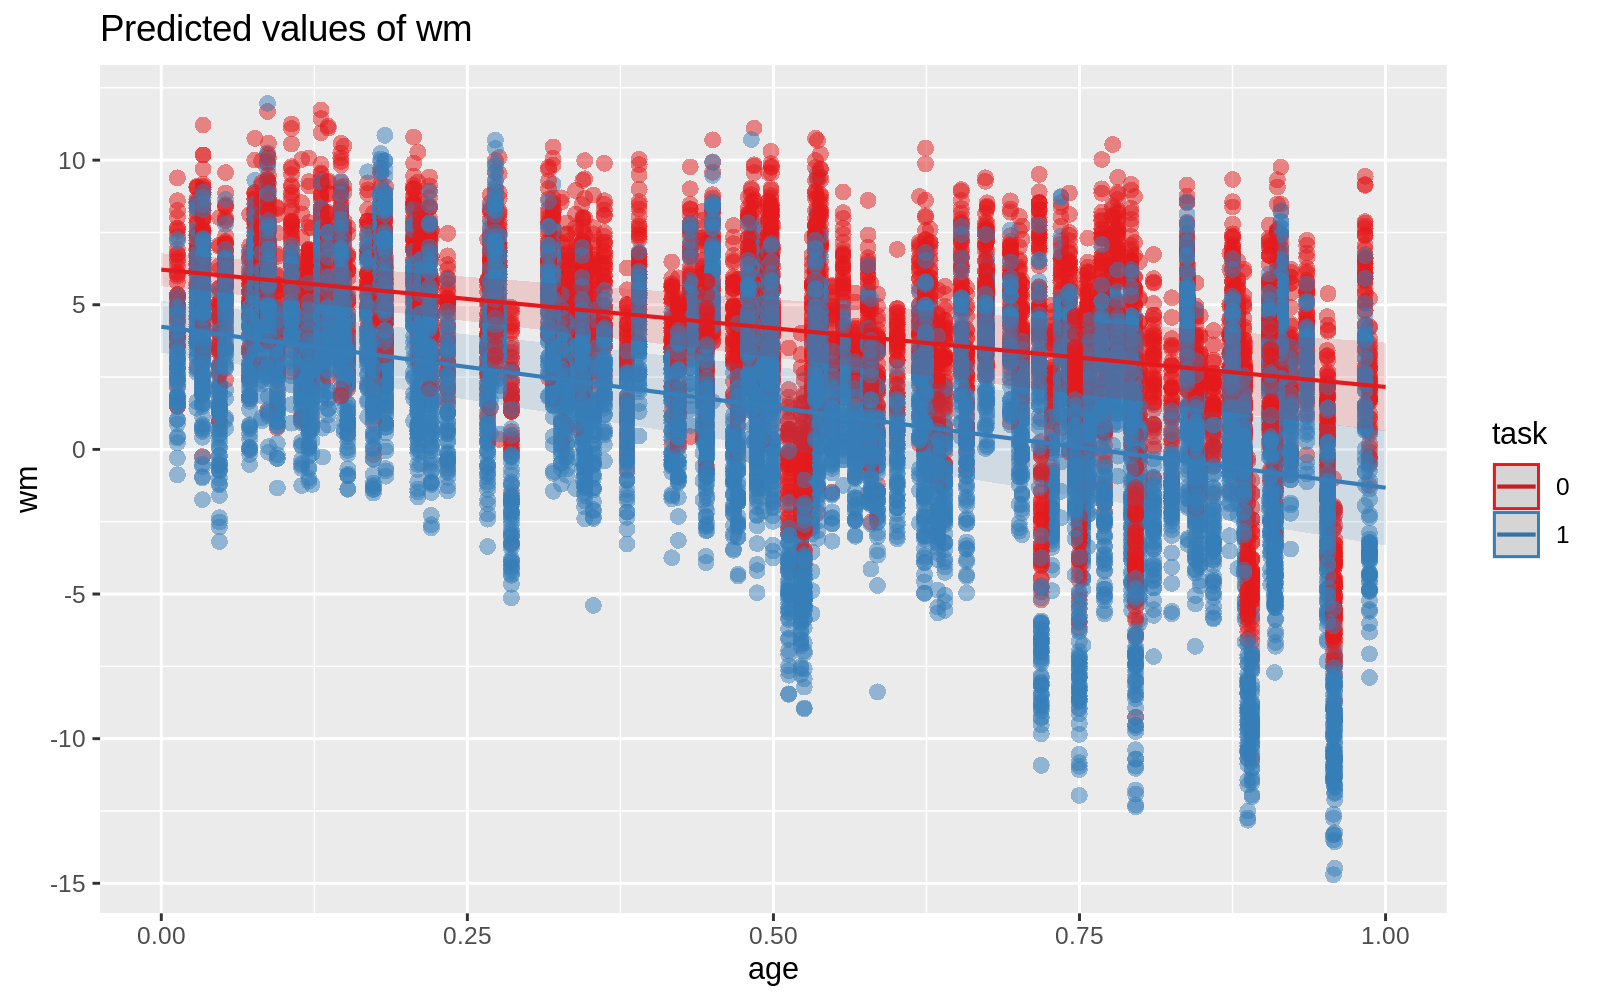

In [64]:
plot_model(full_trial_fullFERE, type = "pred", terms = c("age","task"), show.data = TRUE)

[[1]]

[[2]]


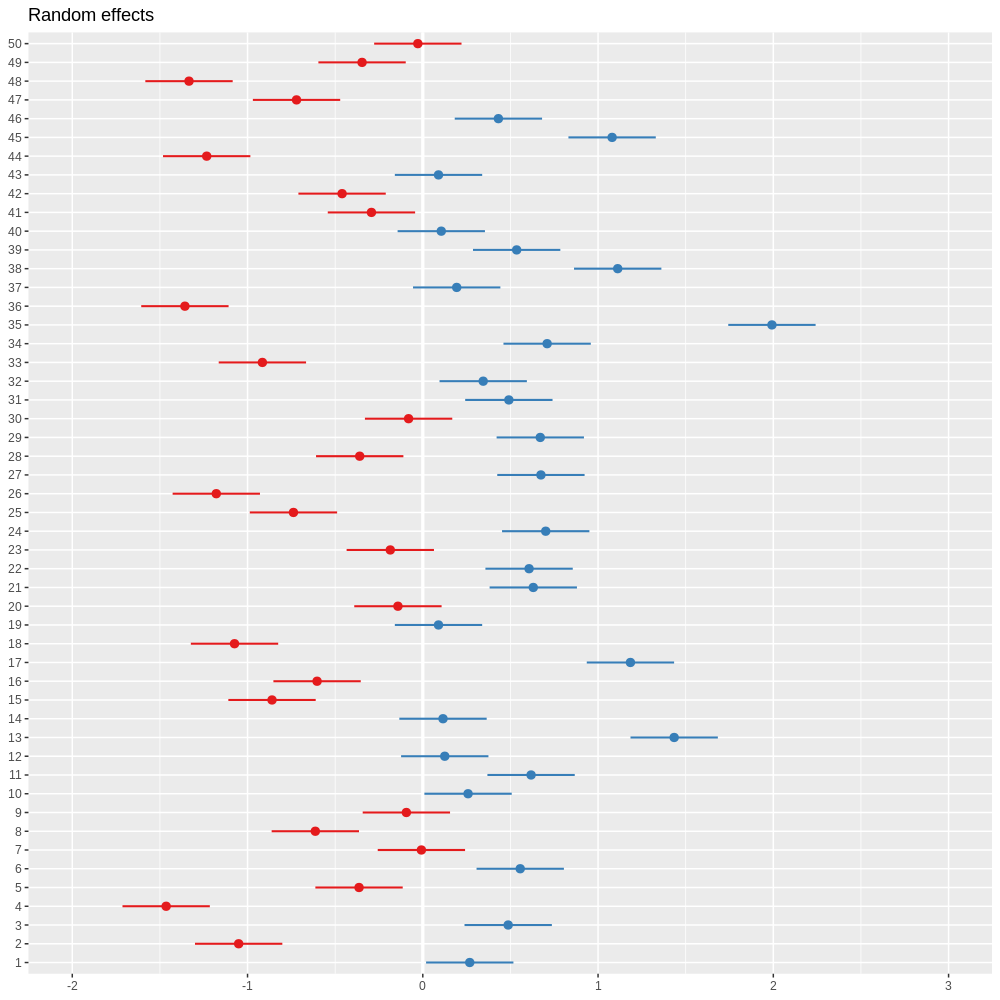

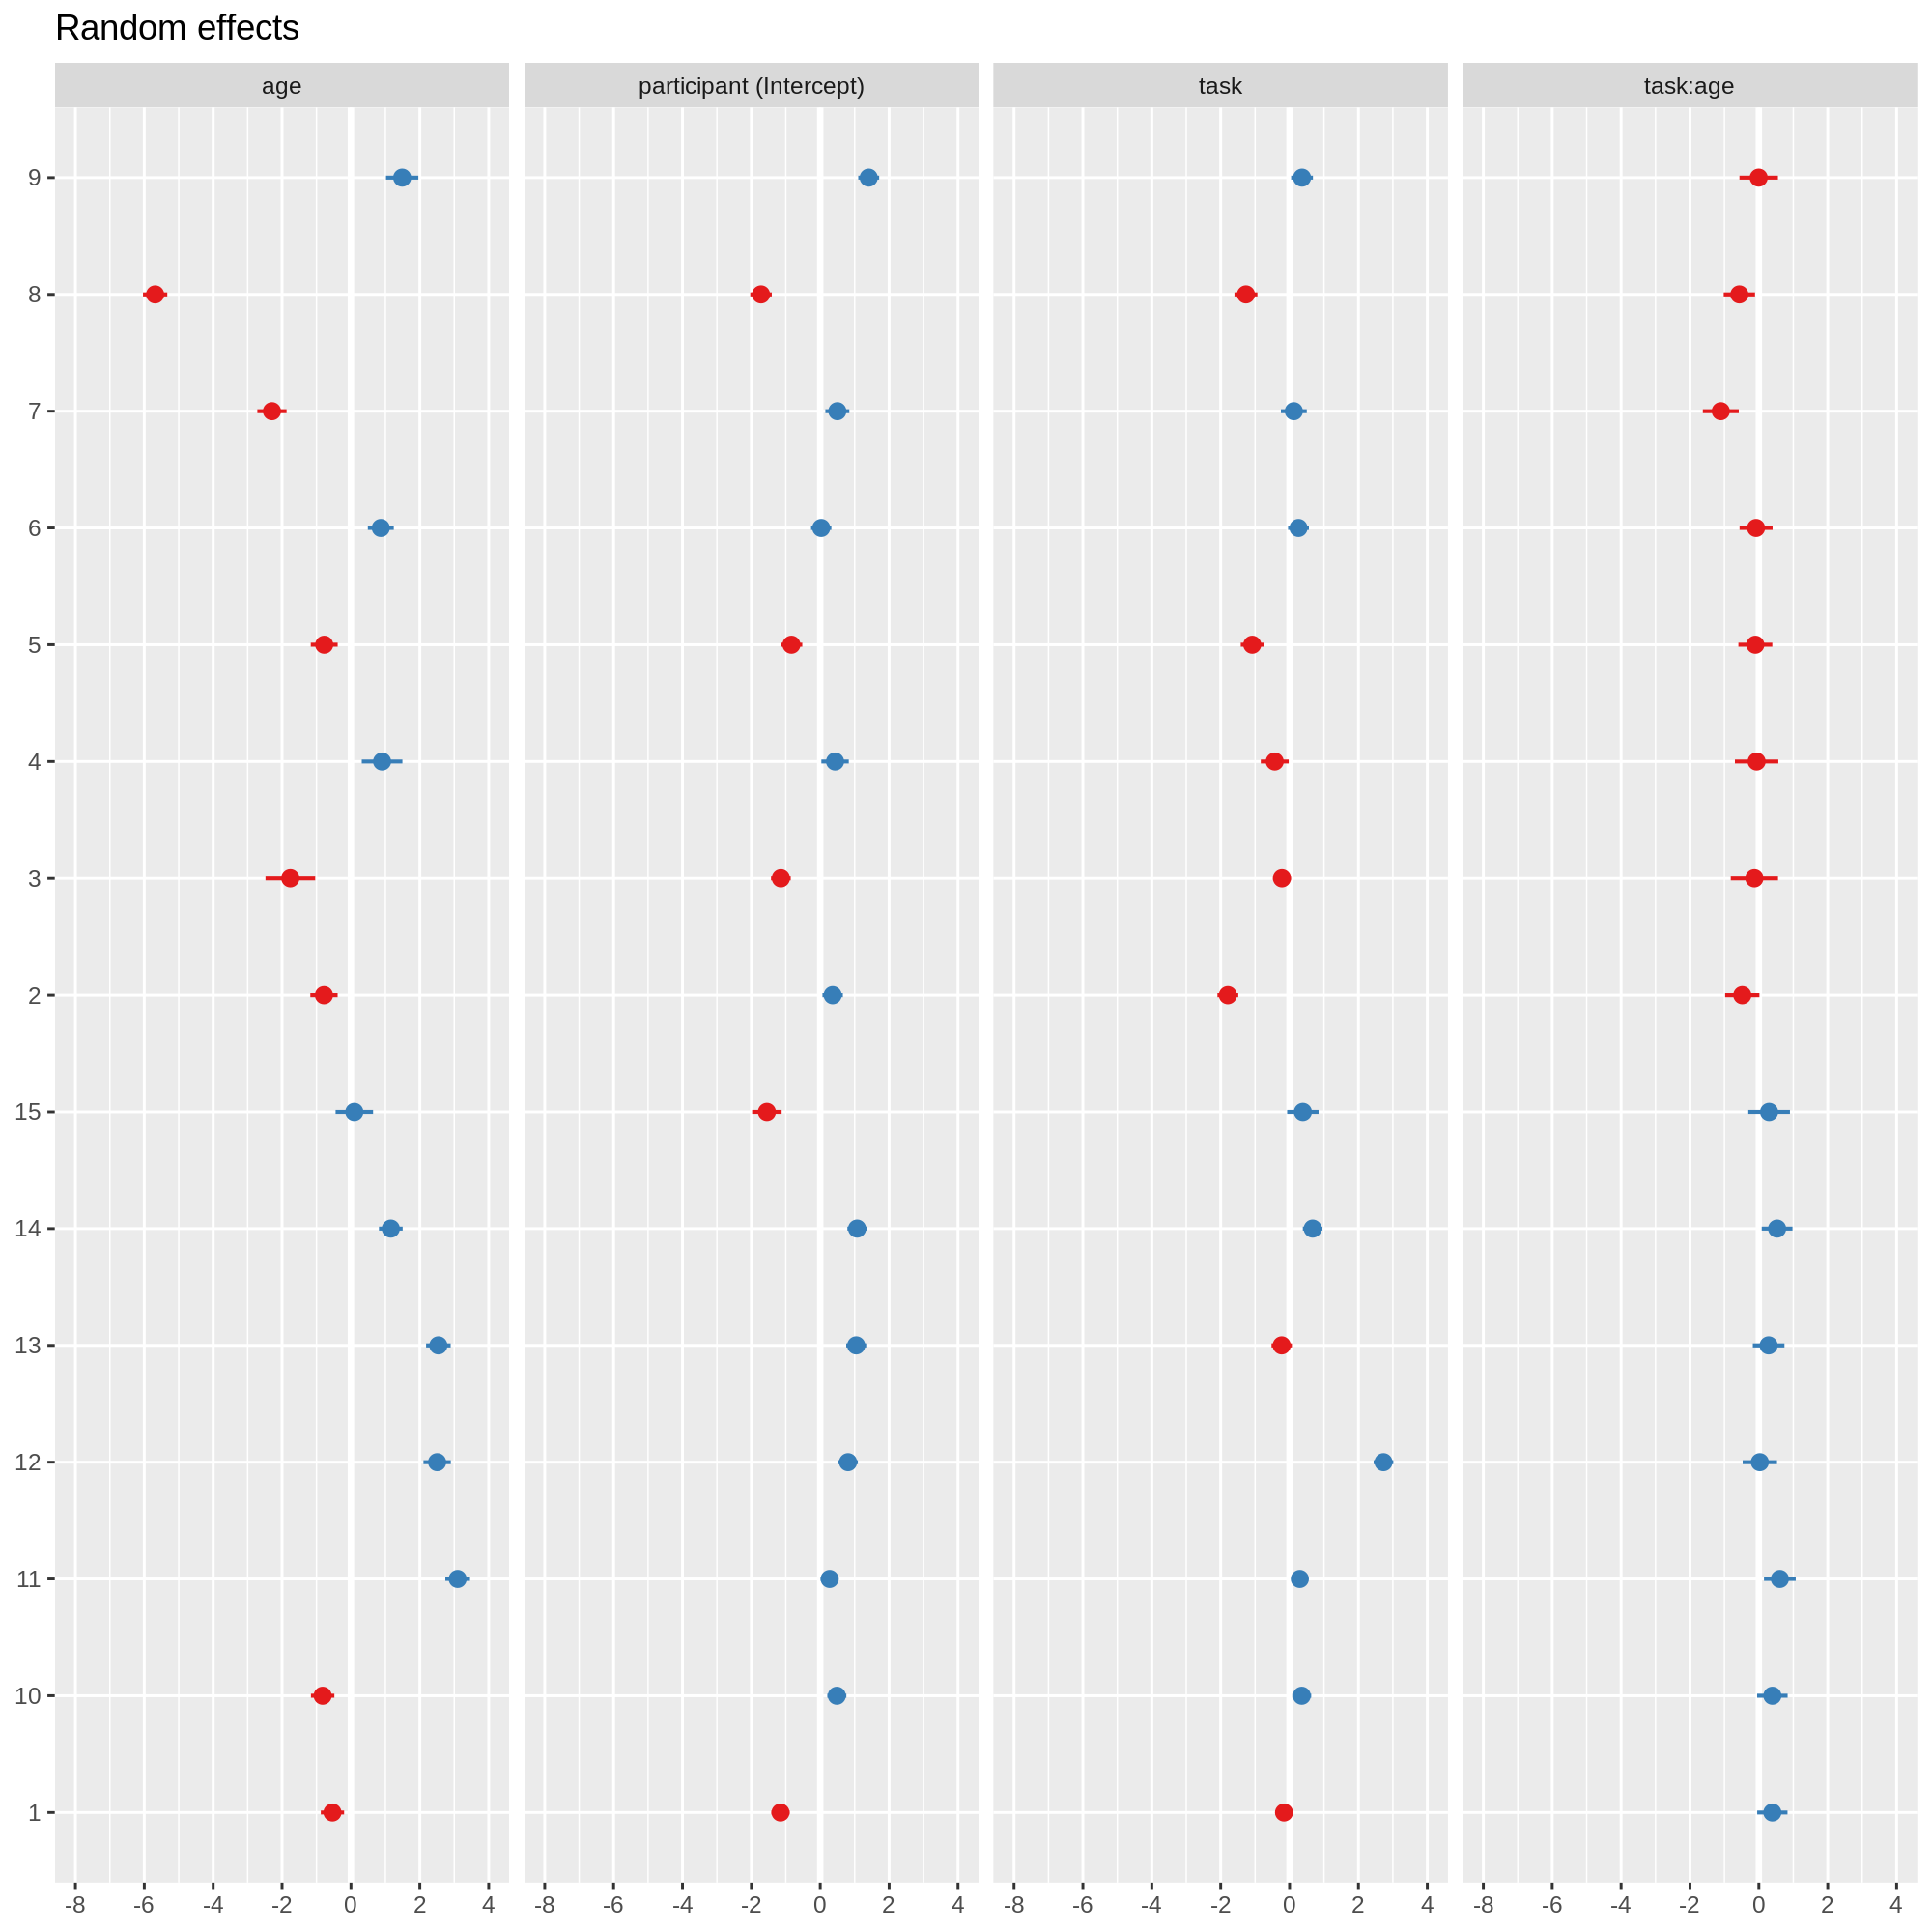

In [65]:
options(repr.plot.width=10, repr.plot.height=10, repr.plot.res = 100)#hidden code for display size
plot_model(full_trial_fullFERE, type = "re")
options(repr.plot.width=8, repr.plot.height=5, repr.plot.res = 200)#hidden code for display size

# Final words for Module 2

Practical advices on LMM : 

- Watch for the difference in scale between your predictors (_e.g._ we rescaled age factor between 0 and 1)
- Carefully think about the contrast of your predictor (centering predictor often helps some convergence problems)
- Be certain to have enough units in the RE (Gelman and Hill, 2007)
- By default, statistical packages such as lme4 assume a normal distribution of these RE
- Think about the relationship between your units (_e.g._ electrodes in an EEG)

If you want to learn more about simulation, mixed models and e.g. power calculation see [DeBruine and Barr  2021](https://psyarxiv.com/xp5cy/)

When using mixed models it is advocated to always keep the random structure maximal [(Barr et al., 2013)](https://www.sciencedirect.com/science/article/pii/S0749596X12001180) but using real data we often end up in computational problems in the estimation. Other language (_e.g._ Julia) ? Bayesian estimation ? 

Moving to module 3 after some practical exercices on the data you brought